## 🗂️ Wczytujemy biblioteki i dane

In [1]:
%run mlflow_make_experiment_JS.ipynb

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
np.random.seed(0)

from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, precision_score, recall_score, make_scorer, confusion_matrix
f_one_half_scorer = make_scorer(fbeta_score, beta = 1.5)

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
import scikitplot as skplt
import seaborn as sns

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [3]:
df_train = pd.read_hdf("../input/train_churn_pred.h5")
df_test = pd.read_hdf("../input/test_churn_pred.h5")

#daty
for x in df_train.columns:
    if x.startswith("date_of"):
        df_train[x] = pd.to_datetime(df_train[x], format = "%m/%d/%Y")
        df_test[x] = pd.to_datetime(df_test[x], format = "%m/%d/%Y")


df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

#zmiana nazw kolumn
df_all.rename(columns = {
                'jun_vbc_3g': 'vbc_3g_6',
                'jul_vbc_3g': 'vbc_3g_7',
                'aug_vbc_3g': 'vbc_3g_8'
                }, inplace = True
             ) 
              
df_train.shape, df_test.shape, df_all.shape

((34999, 171), (35000, 170), (69999, 171))

In [5]:
def save_result(filename, model, feats=None, threshold=0.1, black_list=["id", "churn_probability"]):
    
    df_train = df_all[ df_all["churn_probability"].notnull() ]
    df_test = df_all[ df_all["churn_probability"].isnull() ].copy()

    if feats is None:
        num_feats = df_all.select_dtypes("number").columns
        feats = [x for x in num_feats if x not in black_list]

    
    model.fit(df_train[feats].values, df_train["churn_probability"].values)

    df_test["churn_probability"] = (model.predict_proba(df_test[feats].values)[:,1] > threshold).astype(np.int)
    output_file = "../output/{}".format(filename)
    df_test[ ["id", "churn_probability"] ].to_csv(output_file, index=False)
    print("Saved: ", output_file)

## 👀 Sprawdźmy dane, czyli EDA

niektóre z całej sterty wykresów, które rysowałam i nic z nich nie wynikało


In [6]:
## histogram - uciete wartosci odstajace
def plot_cut_hist(df, feat_name, min_perc = 1, max_perc = 99, cnt_bins = 100):
    #pomijam NA, aby zwrocic wartosc liczbowa
    min_hist = np.nanpercentile( df[feat_name], min_perc )
    max_hist = np.nanpercentile( df[feat_name], max_perc )
    
    min_val = np.min(df[feat_name])
    max_val = np.max(df[feat_name])
    
    (
        df[(df[feat_name] >= min_hist) & (df[feat_name] <= max_hist) ][feat_name]
    ).hist(bins = cnt_bins)
    
    plt.title("{}\n min percentile = {}, max percentile = {}\n min value = {}, max value = {}".format(feat_name, min_perc, max_perc, min_val, max_val))
    plt.show()
    
## histogram wartosci zlogarytmowanych
def plot_log_hist(df, feat_name, cnt_bins = 100):
    np.log(df[df[feat_name]>0][feat_name]).hist(bins=cnt_bins)
    
    plt.title("log {}".format(feat_name))
    plt.show()
    
## 3 wykresy na jednym - histogram z ucietymi wartosciami
def three_plots_cut_hist(df, feat_name_prefix, min_perc = 1, max_perc = 99, cnt_bins = 100):
    fig, axs = plt.subplots(1,3)
    for ind, ax in enumerate(axs):
        feat_name = feat_name_prefix+ str(ind+6)
        
        min_hist = np.nanpercentile( df[feat_name], min_perc )
        max_hist = np.nanpercentile( df[feat_name], max_perc )
    
        min_val = np.min(df[feat_name])
        max_val = np.max(df[feat_name])

        ax.hist(
            df[ (df[feat_name] >= min_hist) & (df[feat_name] <= max_hist) ][feat_name],
            bins = cnt_bins
        )
    
        ax.set_title("{}\n min percentile = {}, max percentile = {}\n min value = {},\n max value = {}\n".format(feat_name, min_perc, max_perc, min_val, max_val))
    
    plt.show()
    
    
## 3 wykresy na jednym - histogram wartosci zlogarytmowanych
def three_plots_log_hist(df, feat_name_prefix, cnt_bins = 100):
    fig, axs = plt.subplots(1,3)
    for ind, ax in enumerate(axs):
        feat_name = feat_name_prefix+ str(ind+6)
    
        ax.hist(
            np.log(df[df[feat_name]>0][feat_name]),
            bins = cnt_bins
        )
    
        ax.set_title("log {}".format(feat_name))
    
    plt.show()

In [7]:
df_train["churn_probability"].value_counts(normalize=True)

0    0.898111
1    0.101889
Name: churn_probability, dtype: float64

In [8]:
df_all.describe()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability
count,69999.000000,69297.0,69297.0,69297.0,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.0,17865.0,18417.0,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.0,17865.00000

In [9]:
# namierzenie zmiennych, maja wartosci ujemne
df_summary = df_all.describe()
neg_val_feats = [column for column in df_summary.columns if df_summary.loc["min"][column]<0]
neg_val_feats

['arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [10]:
df_all[neg_val_feats].describe()

,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
count,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,283.134369,278.185913,278.858826,90.069939,89.115761,90.618561,86.863892,85.846077,86.348404
std,334.213898,344.366913,351.924316,193.600418,195.826996,189.907990,171.321198,178.067276,170.297104
min,-2258.708984,-1289.714966,-945.807983,-20.379999,-26.040001,-24.490000,-35.830002,-13.090000,-55.830002
25%,93.581001,86.714001,84.095001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,197.483994,191.587997,192.233994,0.520000,0.420000,0.840000,11.300000,8.800000,9.090000
75%,370.791000,365.369507,369.908997,122.070000,120.860001,122.070000,122.070000,122.070000,122.070000
max,27731.087891,35145.835938,33543.625000,5054.370117,4980.899902,3716.899902,5054.350098,4809.359863,3483.169922


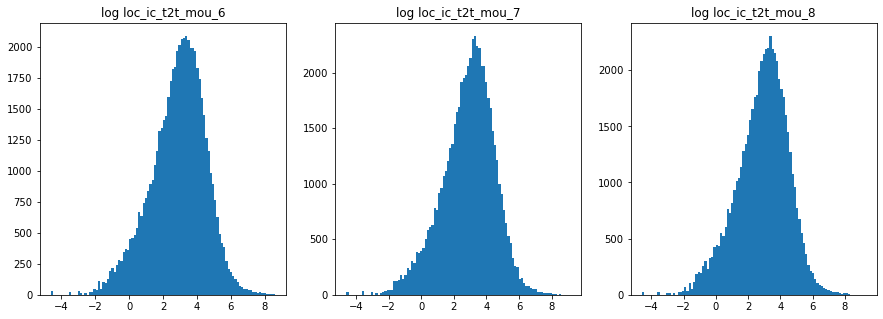

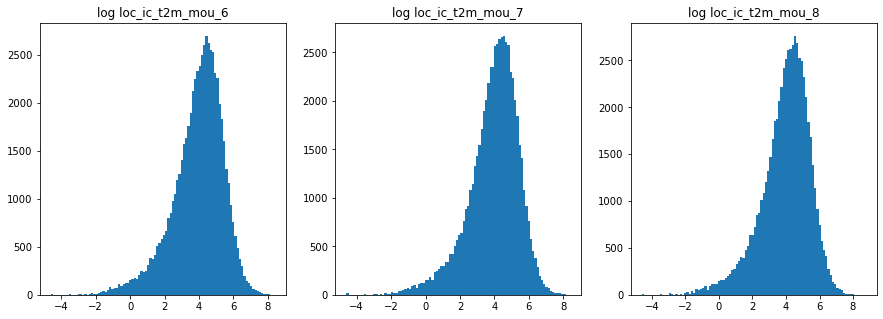

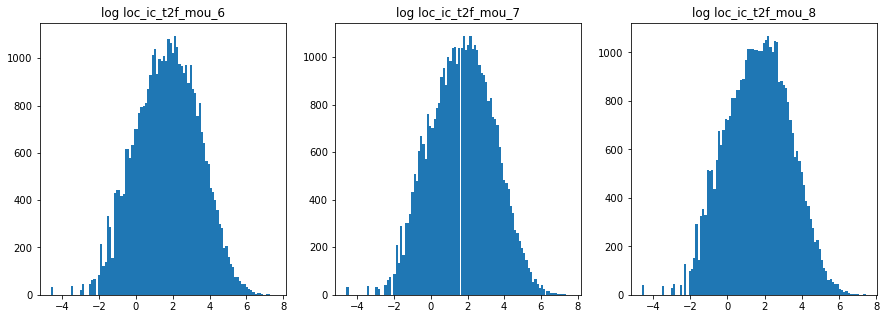

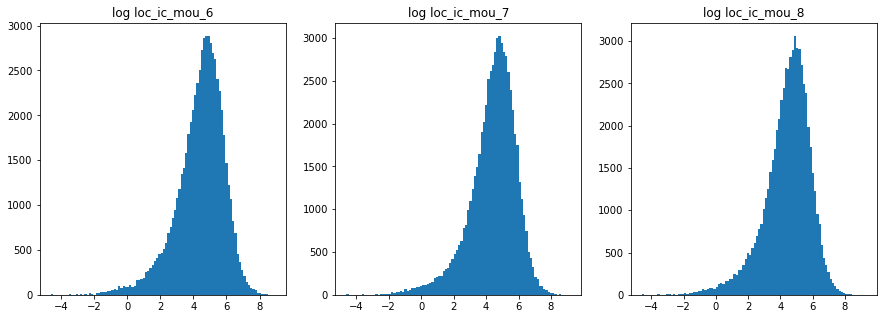

In [11]:
#[x for x in df_all.columns if x.startswith("loc_ic_")]
for x in [
            'loc_ic_t2t_mou_',
            'loc_ic_t2m_mou_',
            'loc_ic_t2f_mou_',
            'loc_ic_mou_',
         ]:
    three_plots_log_hist(df_all, x)

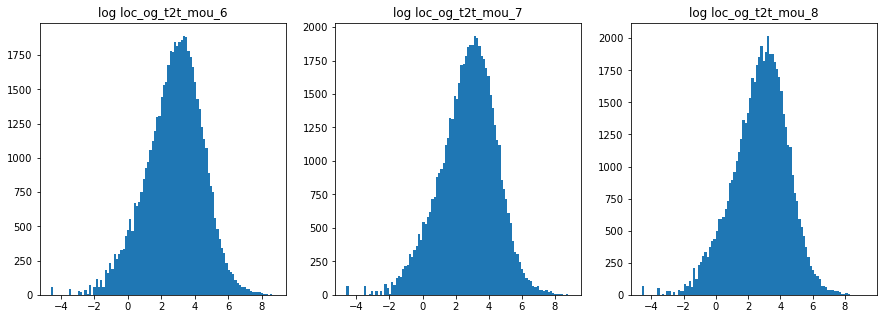

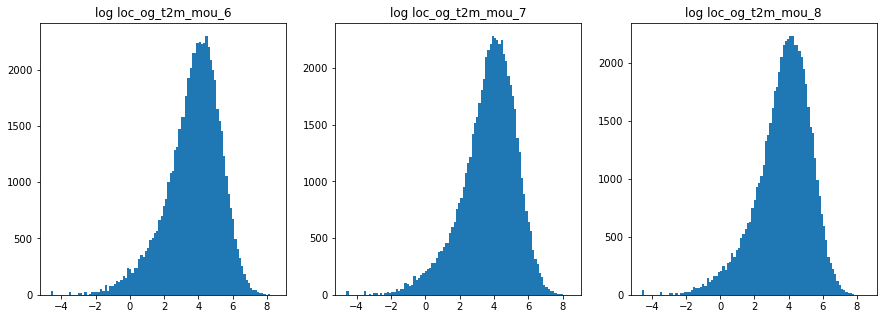

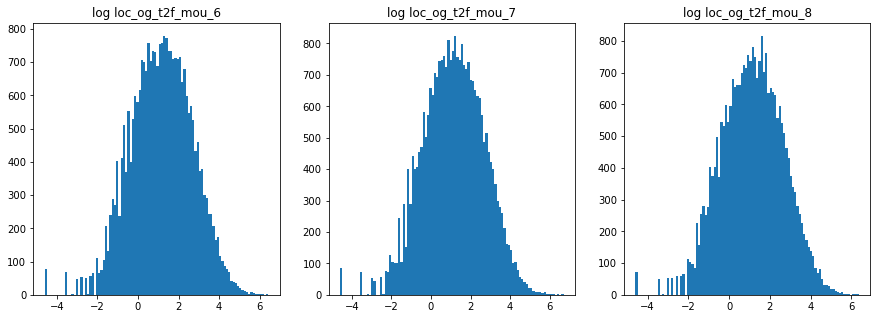

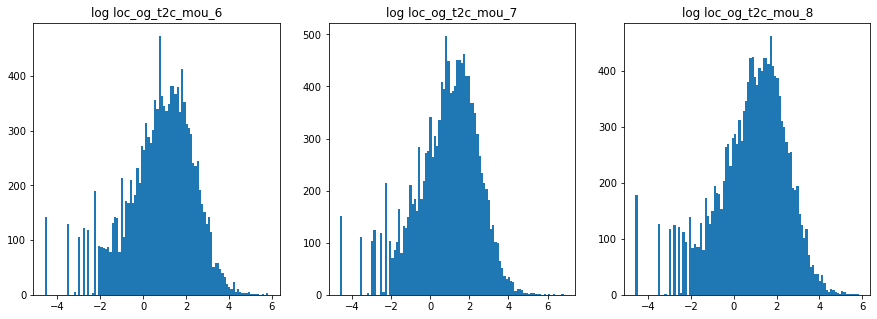

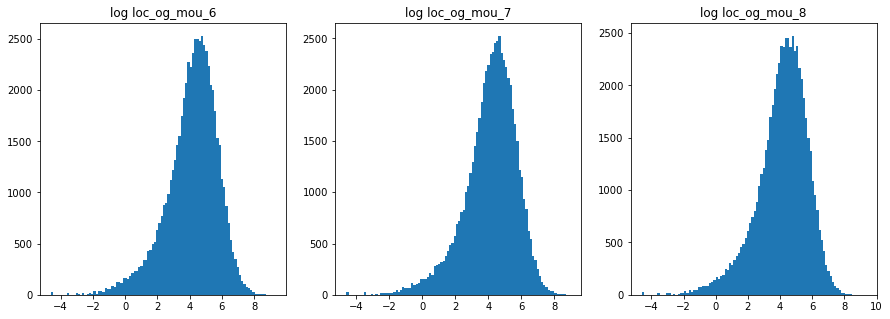

In [12]:
#[x for x in df_all.columns if x.startswith("loc_og_")]
for x in [
         'loc_og_t2t_mou_',
         'loc_og_t2m_mou_',
         'loc_og_t2f_mou_',
         'loc_og_t2c_mou_',
         'loc_og_mou_',
    ]:
    three_plots_log_hist(df_all, x)

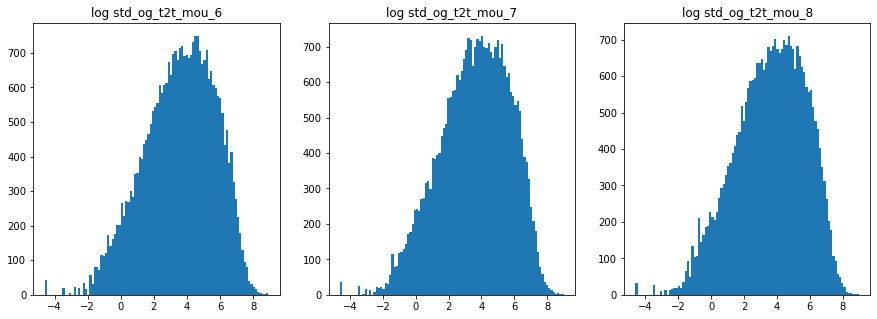

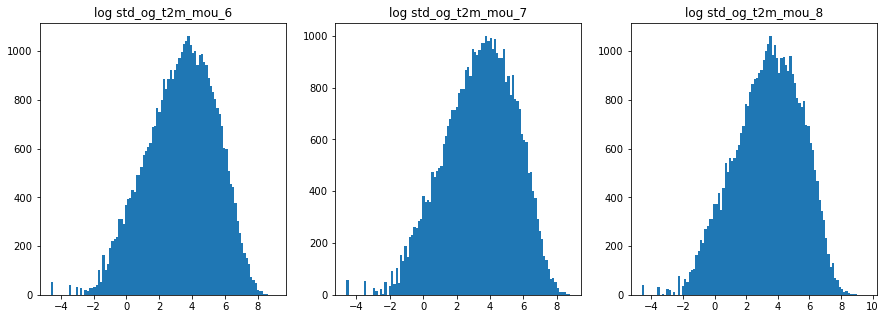

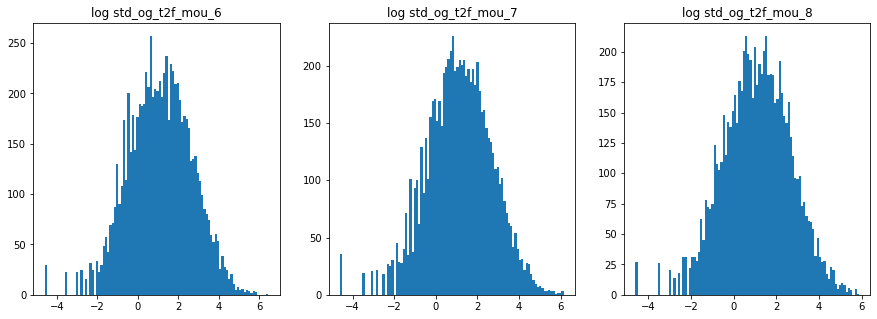

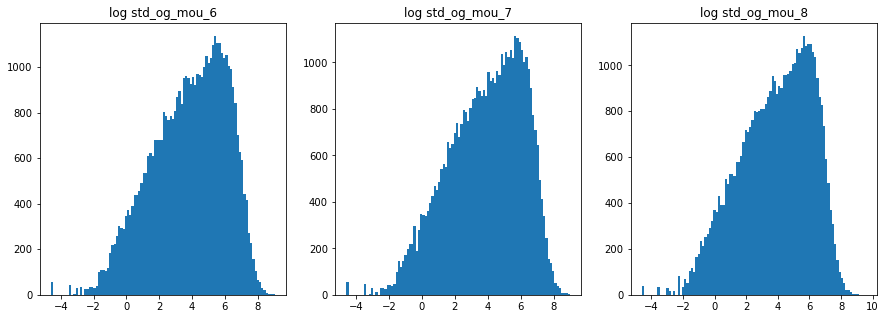

In [13]:
for x in [
         'std_og_t2t_mou_',
         'std_og_t2m_mou_',
         'std_og_t2f_mou_',
         'std_og_mou_',
         ]:
    three_plots_log_hist(df_all, x)

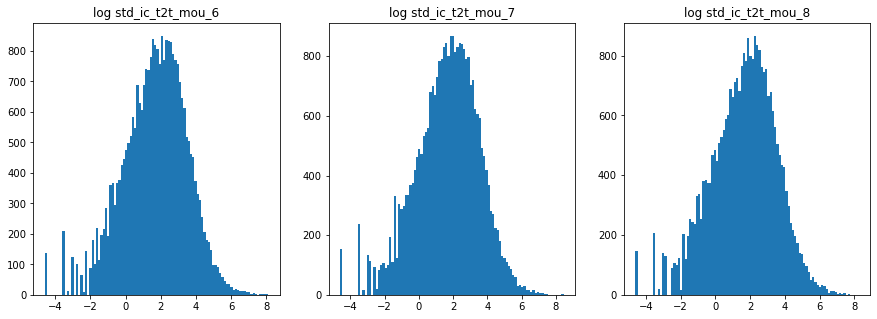

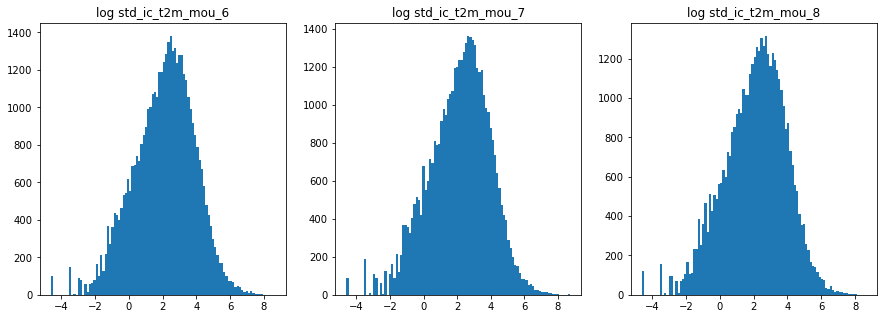

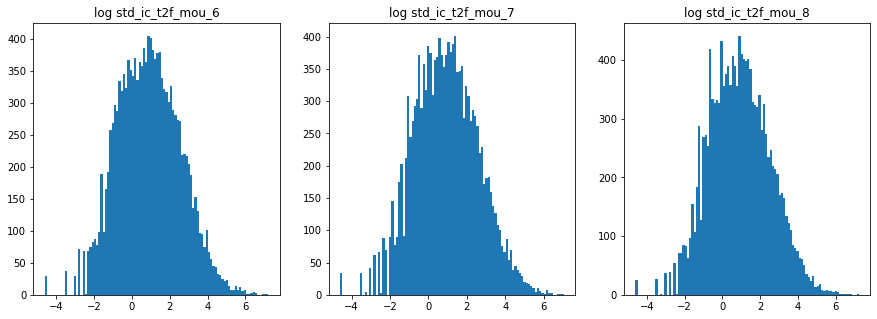

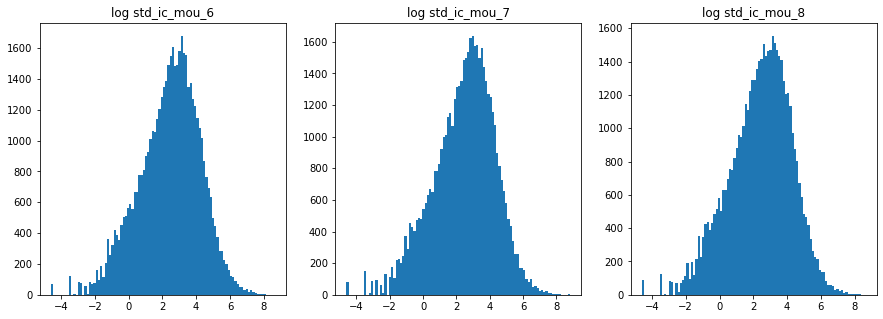

In [14]:
#[x for x in df_all.columns if x.startswith("std_ic_")]
for x in [
         'std_ic_t2t_mou_',
         'std_ic_t2m_mou_',
         'std_ic_t2f_mou_',
         'std_ic_mou_',
         ]:
    three_plots_log_hist(df_all, x)

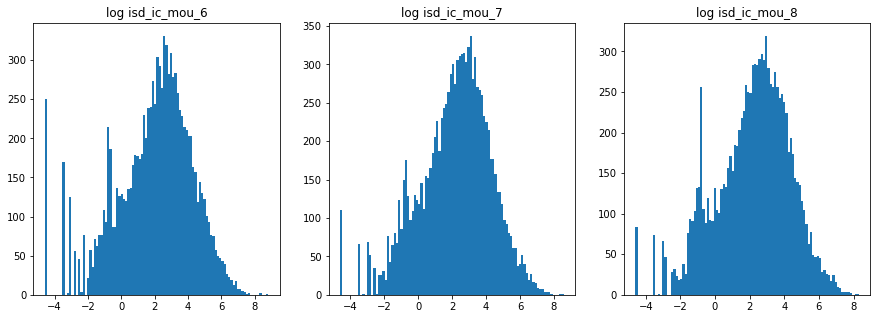

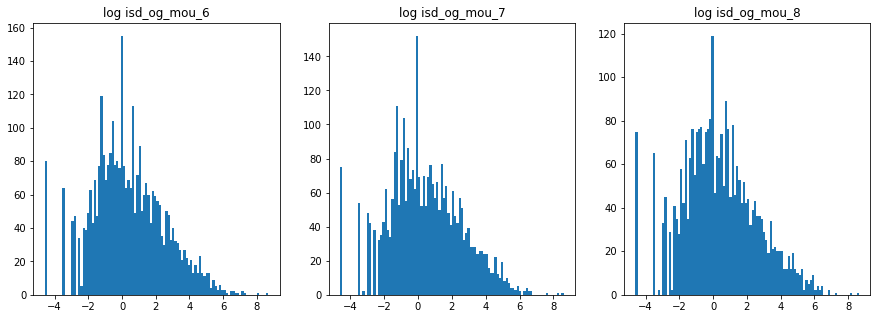

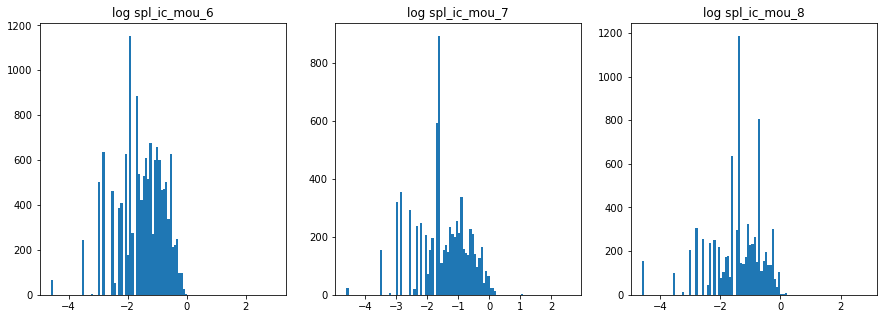

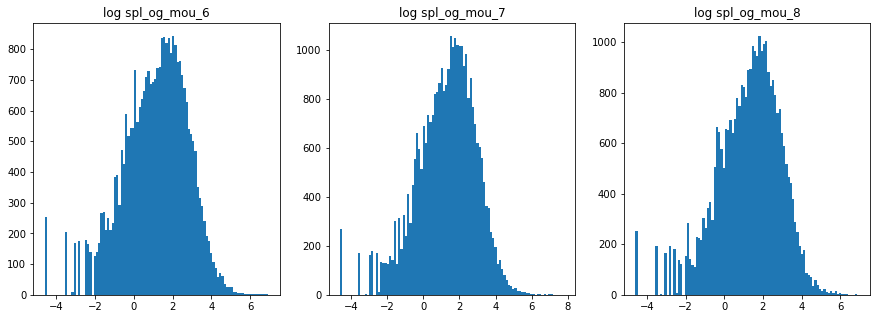

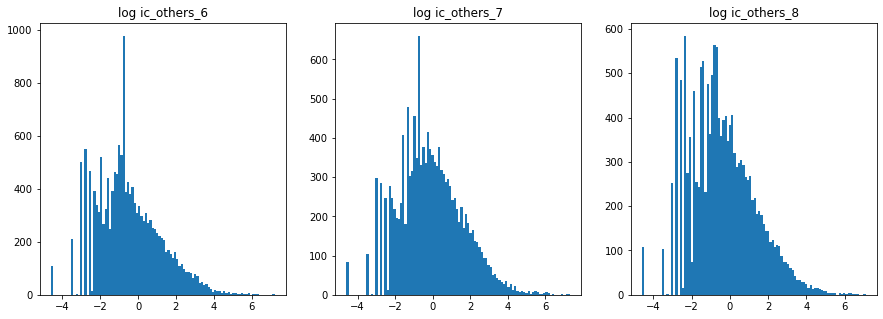

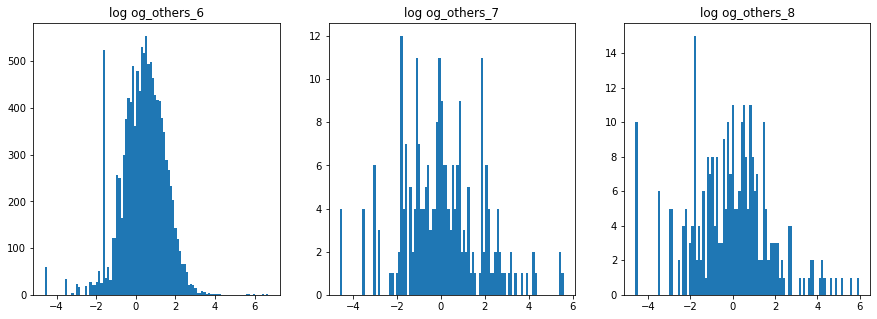

In [15]:
for x in [
         'isd_ic_mou_',
         'isd_og_mou_',
         'spl_ic_mou_',
         'spl_og_mou_',
         'ic_others_',
         'og_others_',   
         ]:
    three_plots_log_hist(df_all, x)

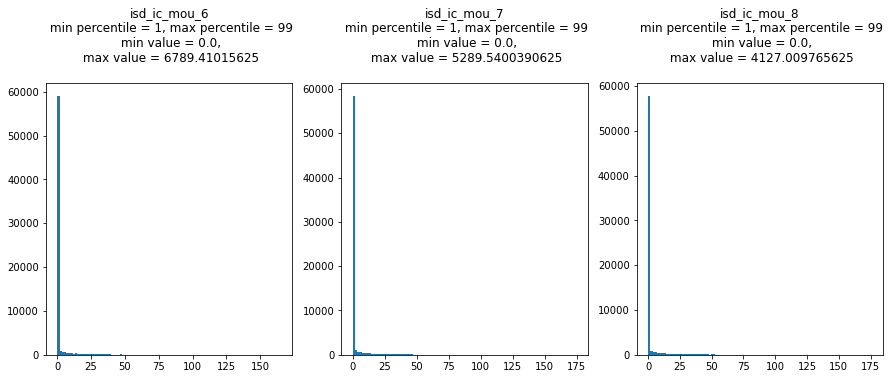

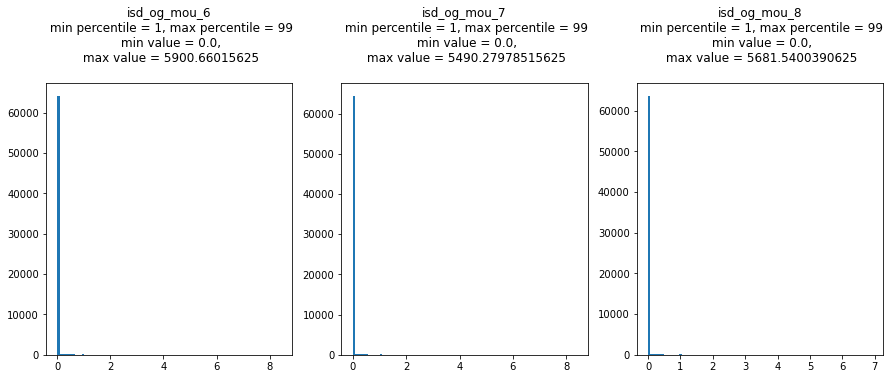

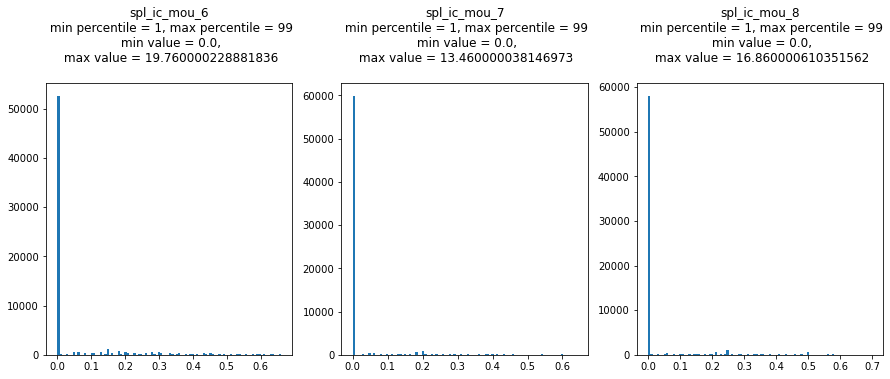

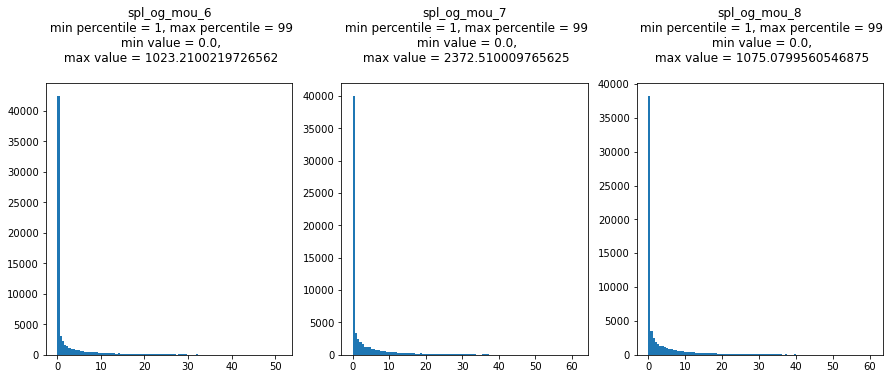

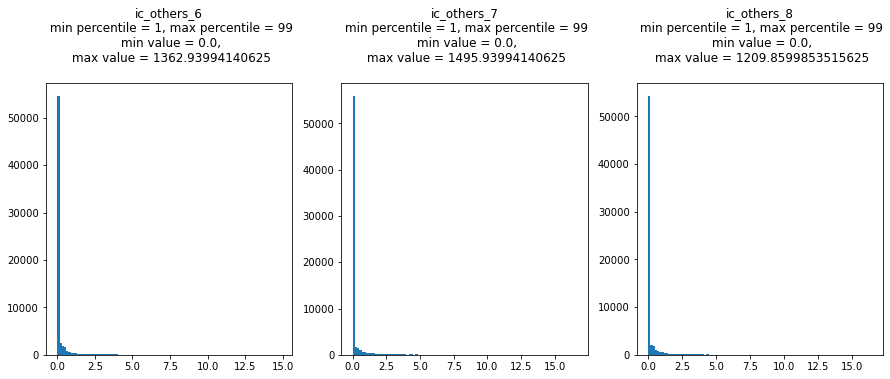

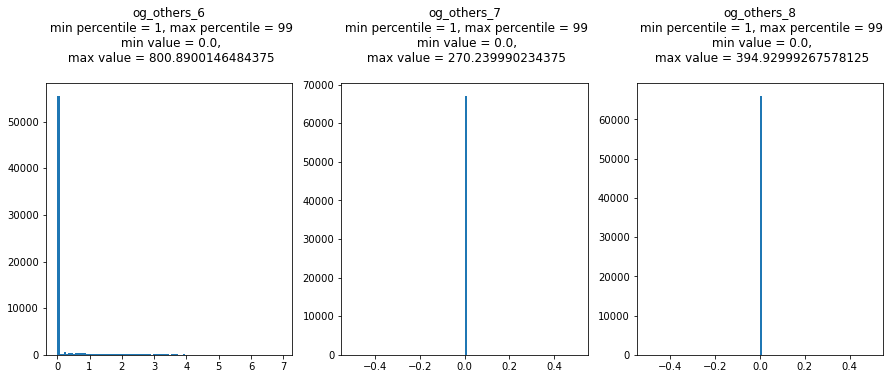

In [16]:
for x in [
         'isd_ic_mou_',
         'isd_og_mou_',
         'spl_ic_mou_',
         'spl_og_mou_',
         'ic_others_',
         'og_others_',   
         ]:
    three_plots_cut_hist(df_all, x)

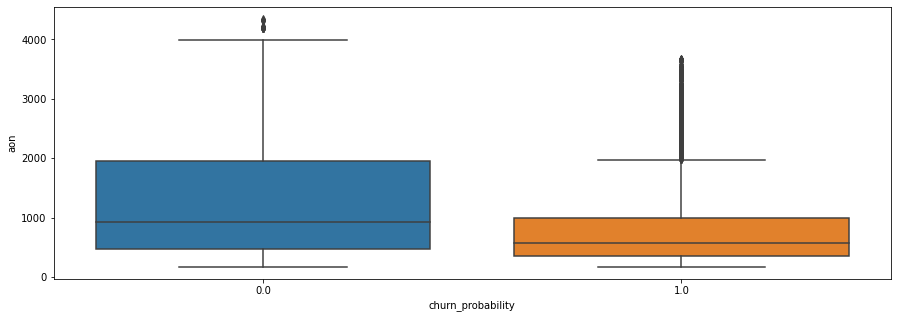

In [17]:
sns.boxplot(data = df_all[df_all['churn_probability'].notna()],
            y = "aon",
            x="churn_probability");

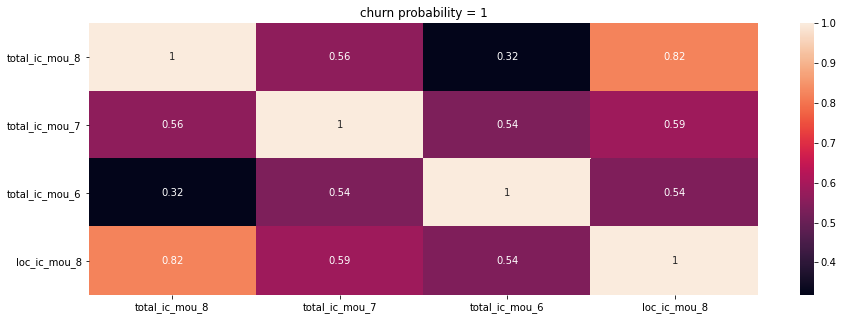

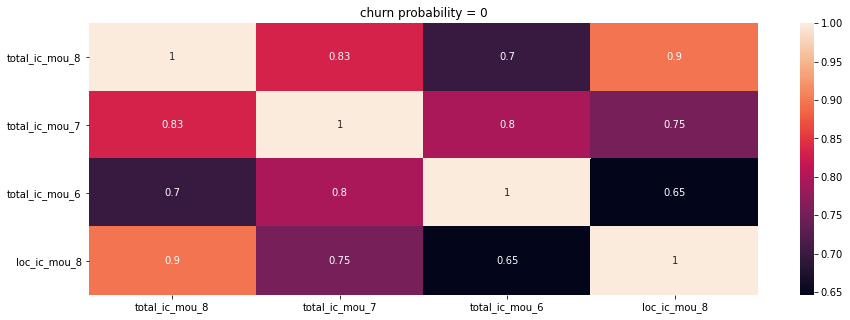

In [18]:
feats_corr = ['total_ic_mou_8', 'total_ic_mou_7','total_ic_mou_6','loc_ic_mou_8']

df_corr = df_all[df_all['churn_probability']==1][feats_corr].corr()
sns.heatmap(df_corr, annot = True)
plt.title("churn probability = 1")
plt.show()

df_corr = df_all[df_all['churn_probability']==0][feats_corr].corr()
sns.heatmap(df_corr, annot = True)
plt.title("churn probability = 0")
plt.show()


# Inżynieria cech
**UWAGA** funkcja fe_v2 jest mało optymalna, przelicza się u mnie ok. 2h

In [20]:
def calc_stats(x, func):
    if pd.isna(x).all():
        return np.nan
    
    return func(x)



def fe_v2(df):
#dopuszczam w zmiennych wartosc np.nan (bede wybierac modele, ktore sobie z tym radza)    
    
    # operacje na datach
    for m in [6,7,8]:
        df["dayofweek_last_rech_" + str(m)] = df["date_of_last_rech_" + str(m)].dt.dayofweek
        df["dayofweek_last_rech_data_" + str(m)] = df["date_of_last_rech_data_" + str(m)].dt.dayofweek
        df["dayofmonth_last_rech_" + str(m)] = df["date_of_last_rech_" + str(m)].dt.day
        df["dayofmonth_last_rech_data_" + str(m)] = df["date_of_last_rech_data_" + str(m)].dt.day
        
        
    # zmienne binarne
    for feat_name in [x for x in df.select_dtypes("number").columns if x not in ["id", "churn_probability"]]:
        df["is_nan_" + feat_name] = df[feat_name].map(lambda x: int(pd.isnull(x)))
        df["is_zero_"+ feat_name] = df[feat_name].map(lambda x: int(x == 0))
        df["is_below_zero_"+ feat_name] = df[feat_name].map(lambda x: int(x < 0))
        
    # zmienne, ktore maja wartosci ujemne 
    #df_summary = df_all.describe()
    #neg_val_feats = [column for column in df_summary.columns if df_summary.loc["min"][column]<0]
    neg_val_feats =[
         'arpu_',
         'arpu_3g_',
         'arpu_2g_',
        ]
    for feat in neg_val_feats:
        for m in [6,7,8]:
            feat_name = feat + str(m)        
            df["neg_val_" + feat_name] = df[feat_name].map(lambda x: np.nan if x >= 0 else x)
    
    
    # zmienne, ktore warto zlogarytmowac - NaN dla <= 0 
    log_feats = [
        "arpu_",
        'arpu_3g_',
        'arpu_2g_',
        "offnet_mou_",
        "onnet_mou_",
        "total_ic_mou_",
        "total_og_mou_",
        "total_rech_amt_",
        "av_rech_amt_data_",
        "roam_ic_mou_",
        "roam_og_mou_",
        "vbc_3g_",
        "vol_2g_mb_",
        "vol_3g_mb_",
        'loc_ic_t2t_mou_',
        'loc_ic_t2m_mou_',
        'loc_ic_t2f_mou_',
        'loc_ic_mou_',
        'loc_og_t2t_mou_',
        'loc_og_t2m_mou_',
        'loc_og_t2f_mou_',
        'loc_og_t2c_mou_',
        'loc_og_mou_',
        'std_ic_t2t_mou_',
        'std_ic_t2m_mou_',
        'std_ic_t2f_mou_',
        'std_ic_mou_',
        'std_og_t2t_mou_',
        'std_og_t2m_mou_',
        'std_og_t2f_mou_',
        'std_og_mou_',
        'isd_ic_mou_',
        'isd_og_mou_',
        'spl_ic_mou_',
        'spl_og_mou_',
        'ic_others_',
        'og_others_', 
    ]
    for feat in log_feats:
        for m in [6,7,8]:
            feat_name = feat + str(m)
            df["log_" + feat_name] = df[feat_name].map(lambda x: np.nan if x <= 0 else np.log(x))
    
    df["log_aon"] = df["aon"].map(lambda x: np.nan if x <= 0 else np.log(x))
    
    # dodatkowe obliczenia dla wybranych zmiennych
#     special_feats = ["total_ic_mou_", "loc_ic_mou_"]
    special_feats = log_feats
    for feat in special_feats:
        # iloraz 8 vs 7 i 8 vs 6, 7 vs 6
        df["change_" + feat + "8vs7"] = df[feat + "8"].div(df[feat + "7"]).replace(np.inf, np.nan)
        df["change_" + feat + "8vs6"] = df[feat + "8"].div(df[feat + "6"]).replace(np.inf, np.nan)
        df["change_" + feat + "7vs6"] = df[feat + "7"].div(df[feat + "6"]).replace(np.inf, np.nan)
        df["change_log_" + feat + "8vs7"] = df["log_" + feat + "8"].div(df["log_" + feat + "7"]).replace(np.inf, np.nan)
        df["change_log_" + feat + "8vs6"] = df["log_" + feat + "8"].div(df["log_" + feat + "6"]).replace(np.inf, np.nan)
        df["change_log_" + feat + "7vs6"] = df["log_" + feat + "7"].div(df["log_" + feat + "6"]).replace(np.inf, np.nan) 
        
        #podstawowe statystyki
        df["sum_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.sum), axis = 1)
        df["min_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.min), axis = 1)
        df["max_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.max), axis = 1)
        df["mean_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.mean), axis = 1)
        df["median_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.median), axis = 1)
        df["log_sum_"+ feat + "3m"] = df["sum_" + feat + "3m"].map(lambda x: np.nan if x <= 0 else np.log(x))
        #...a moze lepiej dzialac na zlogarytmowanych:
        df["sum_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.sum), axis = 1)
        df["min_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.min), axis = 1)
        df["max_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.max), axis = 1)        
        df["mean_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.mean), axis = 1)
        df["median_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.median), axis = 1)
            
        if df[[feat + "6",feat + "7",feat + "8"]].isnull().any().any(): 
            #jesli mam chociaz jedno NaN, to licze wersje zmiennych pomijajace NaN:
            df["nansum_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.nansum), axis = 1)
            df["nanmin_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.nanmin), axis = 1)
            df["nanmax_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.nanmax), axis = 1)
            df["nanmean_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.nanmean), axis = 1)
            df["nanmedian_" + feat + "3m"] = df[[feat + "6",feat + "7",feat + "8"]].apply(lambda x: calc_stats(x,np.nanmedian), axis = 1)
            #...a moze lepiej dzialac na zlogarytmowanych:
            df["nansum_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.nansum), axis = 1)
            df["nanmin_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.nanmin), axis = 1)
            df["nanmax_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.nanmax), axis = 1)        
            df["nanmean_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.nanmean), axis = 1)
            df["nanmedian_log_" + feat + "3m"] = df[["log_" + feat + "6","log_" + feat + "7","log_" + feat + "8"]].apply(lambda x: calc_stats(x,np.nanmedian), axis = 1)
 
    
    # usunienie zmiennych, ktore maja tylko jedna wartosc
    df_summary = df.describe()
    feats_one_val = [x for x in df_summary.columns if df_summary.loc['min'][x]==df_summary.loc['max'][x]]
    
    for feat in feats_one_val:
        df.drop(feat, inplace=True, axis=1)
    

    return df


## 🤖 Eksperymenty


In [21]:
def get_models():    
    
    lgb_params = {    
        'max_depth': 5, 
        'n_estimators': 100,
        'learning_rate': 0.5, 
        'random_state':0
    }

    ctb_params = {
        'n_estimators': 100, 
        'depth': 6, 
        'random_state':0, 
        'learning_rate': 0.5,
        'verbose': False
    }
    
    xgb_params = {    
        'max_depth': 5, 
        'n_estimators': 100,
        'learning_rate': 0.2, 
        'subsample': 0.5, 
        'random_state':0, 
        'colsample_bytree': 0.9
     }   
    
    return [
         ctb.CatBoostClassifier(**ctb_params),
         lgb.LGBMClassifier(**lgb_params),
         xgb.XGBClassifier(**xgb_params)
    ]

def fit_and_predict(model_cls, model_params, X_train, X_test, y_train, threshold):


    model = model_cls(**model_params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
        
    y_pred = (y_pred_proba[:,1]>threshold).astype(np.int)
    
    return y_pred

### Przykładowe eksperymenty w mlflow

In [9]:
df_all = fe_v2(df_all)

df_train = df_all[ df_all["churn_probability"].notnull() ]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34999 entries, 0 to 34998
Columns: 1515 entries, id to nanmedian_log_og_others_3m
dtypes: datetime64[ns](6), float16(25), float32(209), float64(952), int16(10), int32(3), int64(298), int8(12)
memory usage: 366.7 MB


In [34]:
for model in get_models():
    make_experiment(df_train, model, my_tags={"run": "fe_v2"}, extra_params={"idea": "basic"})

In [36]:
#wrzucam na black_list zmienne przerobione w base_fe
transformed_feats = [
        "arpu_",
        'arpu_3g_',
        'arpu_2g_',
        "offnet_mou_",
        "onnet_mou_",
        "total_ic_mou_",
        "total_og_mou_",
        "total_rech_amt_",
        "av_rech_amt_data_",
        "roam_ic_mou_",
        "roam_og_mou_",
        "vbc_3g_",
        "vol_2g_mb_",
        "vol_3g_mb_",
        'loc_ic_t2t_mou_',
        'loc_ic_t2m_mou_',
        'loc_ic_t2f_mou_',
        'loc_ic_mou_',
        'loc_og_t2t_mou_',
        'loc_og_t2m_mou_',
        'loc_og_t2f_mou_',
        'loc_og_t2c_mou_',
        'loc_og_mou_',
        'std_ic_t2t_mou_',
        'std_ic_t2m_mou_',
        'std_ic_t2f_mou_',
        'std_ic_mou_',
        'std_og_t2t_mou_',
        'std_og_t2m_mou_',
        'std_og_t2f_mou_',
        'std_og_mou_',
        'isd_ic_mou_',
        'isd_og_mou_',
        'spl_ic_mou_',
        'spl_og_mou_',
        'ic_others_',
        'og_others_',
    ]

black_list = [a + str(b) for a in transformed_feats for b in [6,7,8]] + ["id", "churn_probability"]

rand_feats = False
my_param = "without transformed feats"

for model in get_models():
    make_experiment(df_train, model, my_tags={"run": "fe_v2"}, extra_params={"idea": my_param},
                   black_list=black_list, make_random_feats=rand_feats)


In [37]:
loc_feats = [x for x in df_all.columns if x.startswith("loc_") or x.startswith("log_loc_")]
black_list = loc_feats + ["id", "churn_probability"]

rand_feats = False
my_param = "without loc feats"

for model in get_models():
    make_experiment(df_train, model, my_tags={"run": "fe_v2"}, extra_params={"idea": my_param},
                   black_list=black_list, make_random_feats=rand_feats)



In [38]:
only_8_feats = [x for x in df_all.select_dtypes("number").columns if x.endswith("_8") ]

rand_feats = False
my_param = "ends with _8"

for model in get_models():
    make_experiment(df_train, model, my_tags={"run": "fe_v2"}, extra_params={"idea": my_param},
                   feats=only_8_feats, make_random_feats=rand_feats)


In [39]:
total_or_log_feats = [x for x in df_all.select_dtypes("number").columns if "total_" in x or x.startswith("log_") ]

rand_feats = False
my_param = "total or log"

for model in get_models():
    make_experiment(df_train, model, my_tags={"run": "fe_v2"}, extra_params={"idea": my_param},
                   feats=total_or_log_feats, make_random_feats=rand_feats)


In [45]:
black_list = ["total_ic_mou_8"] + ["id", "churn_probability"]

rand_feats = False
my_param = "out total_ic_mou_8"

for model in get_models():
    make_experiment(df_train, model, my_tags={"run": "fe_v2"}, extra_params={"idea": my_param},
                   black_list=black_list, make_random_feats=rand_feats)

### Co było dalej...

Po przeprowadzeniu powyższych i wielu innych eksperymentów analizowałam wyniki na mlflow. Z braku czasu wzięłam dla każdego modelu kilka najlepszych wyników i zawęziłam liczbę zmiennych sugerując się wynikami eli5.

## HyperOpt

In [112]:

# definiowanie przestrzeni parametrow do optymalizacji
space_lgb ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'learning_rate': hp.uniform ('x_learning_rate', 0.2, 0.5),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'threshold': hp.uniform('x_threshold', 0.1,0.4)
}
space_ctb = {
    'depth': hp.quniform ('x_depth', 5, 16, 1), 
    'random_state':hp.quniform ('x_random_state', 0, 10000, 50),
    'learning_rate': hp.uniform ('x_learning_rate', 0.2, 0.5),
    'threshold': hp.uniform('x_threshold', 0.1,0.4)
}
space_xgb ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.2, 0.5),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'threshold': hp.uniform('x_threshold', 0.1,0.4)
}


# funkcje do optymalizacji
def objective_lgb(space):
    
    X, y = df_train[lgb_feats].values, df_train['churn_probability'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    lgb_params = {
        'max_depth': int(space['max_depth']), 
        'learning_rate': space['learning_rate'], 
        'random_state': int(space['random_state']),
        'n_estimators': 100, 
    }
    
    y_pred = fit_and_predict(model_cls=lgb.LGBMClassifier, model_params=lgb_params, 
                             X_train=X_train, X_test=X_test, y_train=y_train,
                             threshold=space['threshold'])
    
    score = 1-fbeta_score(y_test, y_pred, beta=1.5)
    
    return{'loss':score, 'status': STATUS_OK }

def objective_xgb(space):
    
    X, y = df_train[xgb_feats].values, df_train['churn_probability'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    xgb_params = {
        'max_depth': int(space['max_depth']), 
        'colsample_bytree': space['colsample_bytree'], 
        'learning_rate': space['learning_rate'], 
        'subsample': space['subsample'], 
        'random_state': int(space['random_state']),
        'n_estimators': 100, 
    }
    
    y_pred = fit_and_predict(model_cls=xgb.XGBClassifier, model_params=xgb_params, 
                             X_train=X_train, X_test=X_test, y_train=y_train,
                             threshold=space['threshold'])
    
    score = 1-fbeta_score(y_test, y_pred, beta=1.5)
    
    return{'loss':score, 'status': STATUS_OK }

def objective_ctb(space):
    
    X, y = df_train[ctb_feats].values, df_train['churn_probability'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
      
    ctb_params = {
        'n_estimators': 100, 
        'depth': int(space['depth']), 
        'learning_rate': space['learning_rate'],
        'random_state':int(space['random_state']), 
        'verbose': False
    }
    
    y_pred = fit_and_predict(model_cls=ctb.CatBoostClassifier, model_params=ctb_params, 
                             X_train=X_train, X_test=X_test, y_train=y_train,
                            threshold=space['threshold'])
    
    score = 1-fbeta_score(y_test, y_pred, beta=1.5)
    
    return{'loss':score, 'status': STATUS_OK }

In [1]:
xgb_feats= [
  "log_loc_ic_t2m_mou_8",
  "dayofmonth_last_rech_8",
  "last_day_rch_amt_8",
  "change_total_ic_mou_8vs6",
  "spl_ic_mou_8",
  "aon",
  "is_zero_roam_og_mou_8",
  "vol_2g_mb_7",
  "total_rech_num_8",
  "is_zero_last_day_rch_amt_8",
  "change_total_ic_mou_8vs7",
  "dayofweek_last_rech_8",
  "total_rech_num_7",
  "loc_ic_mou_8",
  "min_log_loc_ic_mou_3m",
  "roam_og_mou_8",
  "is_nan_arpu_2g_8",
  "change_log_loc_ic_mou_8vs7",
  "log_std_og_t2t_mou_7",
  "max_rech_amt_8",
  "roam_og_mou_6",
  "vol_3g_mb_8",
  "min_log_total_ic_mou_3m",
  "is_zero_spl_ic_mou_8",
  "offnet_mou_7",
  "log_aon",
  "roam_ic_mou_7",
  "log_loc_ic_t2t_mou_8",
  "roam_ic_mou_8",
  "dayofmonth_last_rech_7",
  "spl_og_mou_8",
  "log_loc_ic_t2m_mou_6",
  "log_std_og_t2m_mou_8",
  "std_ic_t2f_mou_7",
  "std_ic_t2f_mou_8",
  "log_arpu_8",
  "log_loc_og_t2m_mou_6",
  "min_loc_ic_mou_3m",
  "change_loc_ic_mou_8vs7",
  "change_log_total_ic_mou_8vs7",
  "onnet_mou_6",
  "last_day_rch_amt_7",
  "log_std_og_mou_7",
  "log_onnet_mou_7",
  "change_log_total_ic_mou_8vs6",
  "loc_ic_t2m_mou_8",
  "roam_og_mou_7",
  "std_og_t2t_mou_7",
  "log_total_ic_mou_8",
  "total_ic_mou_8",
  "fb_user_8",
  "arpu_2g_8",
  "av_rech_amt_data_8",
  "change_arpu_8vs7",
  "log_roam_og_mou_8",
  "max_std_og_t2t_mou_3m",
  "log_vol_3g_mb_8",
  "min_roam_ic_mou_3m",
  "median_loc_og_t2c_mou_3m",
  "log_roam_ic_mou_8",
  "std_og_mou_7",
  "change_av_rech_amt_data_8vs7",
  "change_log_total_rech_amt_8vs7",
  "max_loc_ic_t2f_mou_3m",
  "change_log_total_og_mou_8vs7",
  "min_log_loc_og_t2f_mou_3m",
  "log_sum_vol_2g_mb_3m",
  "change_loc_ic_t2f_mou_8vs6",
  "sum_log_total_ic_mou_3m",
  "change_log_total_og_mou_8vs6",
  "median_loc_ic_t2f_mou_3m",
  "sum_log_vol_3g_mb_3m",
  "change_std_og_t2m_mou_7vs6",
  "change_log_offnet_mou_7vs6",
  "is_zero_roam_ic_mou_8",
  "nanmedian_std_ic_t2m_mou_3m",
  "nanmedian_std_og_t2m_mou_3m",
  "min_log_isd_og_mou_3m",
  "std_og_t2f_mou_6",
  "min_spl_ic_mou_3m",
  "nanmedian_roam_ic_mou_3m",
  "max_spl_ic_mou_3m"
]

In [2]:
len(xgb_feats)

82

In [113]:
trials = Trials()
best_params = fmin(fn=objective_xgb,
            space=space_xgb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("XGB The best params: ", best_params)

100%|██████████| 30/30 [12:44<00:00, 25.48s/trial, best loss: 0.2801582069874754] 
XGB The best params:  {'x_colsample_bytree': 0.9288798871876155, 'x_learning_rate': 0.20266986122527608, 'x_max_depth': 9.0, 'x_random_state': 5600.0, 'x_subsample': 0.8901503424181296, 'x_threshold': 0.10432533537271751}


In [3]:
ctb_feats = [
  "dayofmonth_last_rech_8",
  "is_zero_total_ic_mou_8",
  "log_roam_og_mou_8",
  "change_log_loc_ic_mou_8vs7",
  "change_total_rech_amt_8vs7",
  "is_zero_last_day_rch_amt_8",
  "change_total_ic_mou_8vs7",
  "last_day_rch_amt_8",
  "dayofmonth_last_rech_7",
  "aon",
  "change_arpu_3g_7vs6",
  "roam_og_mou_8",
  "sum_arpu_3m",
  "nanmedian_log_spl_ic_mou_3m",
  "total_rech_num_8",
  "median_loc_ic_t2m_mou_3m",
  "total_rech_num_7",
  "log_aon",
  "change_log_total_rech_amt_8vs7",
  "max_rech_amt_8",
  "log_spl_ic_mou_8",
  "max_log_arpu_3m",
  "dayofmonth_last_rech_data_8",
  "log_arpu_8",
  "min_log_roam_ic_mou_3m",
  "log_loc_og_mou_7",
  "min_log_total_ic_mou_3m",
  "onnet_mou_8",
  "change_loc_ic_t2m_mou_7vs6",
  "change_log_total_ic_mou_8vs7",
  "median_roam_og_mou_3m",
  "change_log_roam_og_mou_8vs7",
  "total_rech_amt_8",
  "dayofweek_last_rech_7",
  "arpu_8",
  "nanmin_log_loc_ic_t2t_mou_3m",
  "change_offnet_mou_8vs7",
  "dayofmonth_last_rech_data_7",
  "log_sum_std_ic_t2t_mou_3m",
  "change_offnet_mou_7vs6",
  "min_log_arpu_3m",
  "nanmean_loc_og_t2c_mou_3m",
  "change_log_std_ic_t2t_mou_7vs6",
  "max_rech_amt_6",
  "change_roam_ic_mou_8vs7",
  "loc_ic_mou_8",
  "median_total_ic_mou_3m",
  "sachet_2g_6",
  "change_roam_ic_mou_8vs6",
  "total_og_mou_7",
  "is_zero_loc_ic_mou_8",
  "change_std_og_t2t_mou_7vs6",
  "max_rech_amt_7",
  "change_loc_ic_t2m_mou_8vs7",
  "change_total_rech_amt_8vs6",
  "mean_log_arpu_3m",
  "log_loc_ic_t2t_mou_8",
  "roam_ic_mou_7",
  "sum_log_vol_2g_mb_3m",
  "change_log_arpu_7vs6",
  "change_log_loc_ic_t2t_mou_7vs6",
  "nanmax_log_loc_ic_mou_3m",
  "change_loc_og_t2m_mou_7vs6",
  "log_arpu_6",
  "log_ic_others_6",
  "nansum_offnet_mou_3m",
  "nanmedian_log_loc_ic_mou_3m",
  "change_offnet_mou_8vs6",
  "change_log_roam_og_mou_7vs6",
  "change_log_loc_ic_mou_7vs6",
  "change_log_spl_og_mou_8vs6",
  "log_roam_og_mou_7",
  "change_roam_og_mou_8vs6",
  "change_ic_others_8vs7",
  "mean_log_total_rech_amt_3m",
  "change_loc_og_mou_7vs6",
  "change_log_loc_ic_t2m_mou_8vs7",
  "change_total_ic_mou_8vs6",
  "change_std_og_t2m_mou_7vs6",
  "log_sum_arpu_3m",
  "change_onnet_mou_8vs6",
  "change_loc_og_mou_8vs7",
  "change_log_std_og_mou_7vs6",
  "total_rech_num_6",
  "change_log_roam_og_mou_8vs6",
  "nanmean_log_onnet_mou_3m",
  "min_log_spl_og_mou_3m",
  "mean_log_total_ic_mou_3m",
  "mean_log_isd_ic_mou_3m",
  "arpu_2g_8",
  "change_loc_ic_t2f_mou_8vs7",
  "nanmax_log_offnet_mou_3m",
  "nanmedian_loc_ic_t2m_mou_3m",
  "min_roam_og_mou_3m",
  "change_loc_ic_mou_8vs7",
  "mean_log_total_og_mou_3m",
  "log_ic_others_7",
  "min_log_loc_ic_mou_3m",
  "nanmedian_log_offnet_mou_3m",
  "log_std_ic_t2m_mou_6",
  "nanmedian_log_roam_ic_mou_3m",
  "change_isd_ic_mou_8vs7",
  "dayofmonth_last_rech_6",
  "log_total_ic_mou_8",
  "change_arpu_8vs7",
  "change_roam_og_mou_8vs7",
  "nanmin_log_loc_ic_t2m_mou_3m",
  "change_arpu_7vs6",
  "nanmedian_loc_og_t2c_mou_3m",
  "loc_og_t2f_mou_7",
  "log_offnet_mou_6",
  "sum_log_std_ic_t2m_mou_3m",
  "max_arpu_3m",
  "sum_loc_og_t2t_mou_3m",
  "log_sum_loc_ic_t2m_mou_3m",
  "change_arpu_8vs6",
  "change_loc_og_t2c_mou_7vs6",
  "nansum_loc_og_mou_3m",
  "change_loc_ic_mou_8vs6",
  "change_log_offnet_mou_8vs7",
  "dayofweek_last_rech_data_7",
  "change_vol_3g_mb_8vs7",
  "log_sum_std_og_t2m_mou_3m",
  "change_roam_og_mou_7vs6",
  "nanmin_log_loc_og_t2t_mou_3m",
  "nanmin_roam_ic_mou_3m",
  "loc_og_t2f_mou_8",
  "sum_log_total_ic_mou_3m",
  "change_log_loc_og_t2t_mou_7vs6",
  "change_log_arpu_8vs6",
  "median_loc_og_t2t_mou_3m",
  "log_loc_og_t2t_mou_7",
  "change_std_og_mou_8vs7",
  "change_roam_ic_mou_7vs6",
  "loc_ic_t2m_mou_7",
  "change_isd_og_mou_8vs7",
  "nanmedian_std_og_t2t_mou_3m",
  "std_og_t2m_mou_6",
  "sum_log_offnet_mou_3m",
  "median_arpu_3m",
  "change_std_ic_t2t_mou_8vs7",
  "change_loc_ic_t2t_mou_7vs6",
  "nanmean_offnet_mou_3m",
  "change_vol_2g_mb_7vs6",
  "change_log_total_og_mou_7vs6",
  "nanmedian_og_others_3m",
  "change_loc_og_t2m_mou_8vs6",
  "dayofmonth_last_rech_data_6",
  "change_log_arpu_8vs7",
  "sum_log_total_rech_amt_3m",
  "min_roam_ic_mou_3m",
  "change_log_ic_others_8vs6",
  "log_sum_total_rech_amt_3m",
  "is_nan_loc_og_t2o_mou",
  "change_std_ic_mou_7vs6",
  "change_loc_og_t2t_mou_8vs7",
  "change_log_roam_ic_mou_8vs6",
  "change_loc_ic_mou_7vs6",
  "change_spl_og_mou_7vs6",
  "nansum_log_loc_og_t2t_mou_3m",
  "change_log_loc_og_t2f_mou_8vs7",
  "log_loc_ic_t2m_mou_8",
  "nanmin_log_offnet_mou_3m",
  "change_log_roam_ic_mou_8vs7",
  "count_rech_3g_7",
  "nanmin_og_others_3m",
  "count_rech_2g_8",
  "nansum_onnet_mou_3m",
  "sachet_2g_8",
  "log_roam_ic_mou_8"
]

In [4]:
len(ctb_feats)

170

In [115]:
trials = Trials()
best_params = fmin(fn=objective_ctb,
            space=space_ctb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("CTB The best params: ", best_params)

100%|██████████| 30/30 [40:41<00:00, 81.37s/trial, best loss: 0.2750295236845558]  
CTB The best params:  {'x_depth': 6.0, 'x_learning_rate': 0.2009771366639844, 'x_random_state': 7000.0, 'x_threshold': 0.1914580157640478}


In [5]:
lgb_feats = [
  "total_ic_mou_8",
  "fb_user_8",
  "dayofmonth_last_rech_8",
  "change_total_ic_mou_8vs7",
  "last_day_rch_amt_8",
  "roam_ic_mou_8",
  "log_roam_og_mou_8",
  "change_log_total_ic_mou_8vs6",
  "log_roam_ic_mou_8",
  "change_log_total_ic_mou_8vs7",
  "aon",
  "total_rech_num_7",
  "std_og_mou_7",
  "roam_og_mou_7",
  "roam_og_mou_8",
  "total_rech_num_8",
  "min_loc_ic_mou_3m",
  "spl_ic_mou_8",
  "mean_log_loc_ic_mou_3m",
  "log_loc_ic_t2m_mou_6",
  "loc_og_mou_8",
  "total_og_mou_8",
  "log_arpu_7",
  "log_onnet_mou_8",
  "dayofmonth_last_rech_7",
  "log_arpu_6",
  "log_offnet_mou_7",
  "change_log_loc_ic_mou_8vs7",
  "log_spl_og_mou_7",
  "log_onnet_mou_7",
  "onnet_mou_8",
  "max_loc_ic_mou_3m",
  "std_og_t2t_mou_6",
  "log_total_rech_amt_7",
  "loc_og_t2m_mou_6",
  "log_std_og_mou_7",
  "log_roam_ic_mou_7",
  "log_loc_og_t2t_mou_8",
  "total_rech_amt_7",
  "log_std_og_mou_8",
  "log_loc_ic_t2t_mou_8",
  "change_total_ic_mou_8vs6",
  "log_total_rech_amt_8",
  "std_ic_mou_7",
  "log_roam_og_mou_6",
  "log_std_og_t2t_mou_7",
  "loc_og_t2t_mou_8",
  "log_std_ic_t2t_mou_6",
  "av_rech_amt_data_8",
  "log_loc_og_t2t_mou_7",
  "loc_ic_t2t_mou_6",
  "log_total_og_mou_6",
  "log_std_ic_t2m_mou_8",
  "log_std_ic_t2t_mou_7",
  "loc_og_t2m_mou_8",
  "log_spl_ic_mou_6",
  "log_total_rech_amt_6",
  "log_arpu_8",
  "log_std_og_t2t_mou_8",
  "log_total_og_mou_8",
  "log_std_ic_mou_8",
  "dayofmonth_last_rech_data_8",
  "min_log_loc_ic_mou_3m",
  "log_roam_og_mou_7",
  "roam_ic_mou_6",
  "max_rech_amt_6",
  "log_loc_og_t2m_mou_8",
  "log_loc_ic_t2f_mou_6",
  "total_rech_num_6",
  "total_rech_amt_6",
  "dayofmonth_last_rech_6",
  "roam_ic_mou_7",
  "loc_ic_t2m_mou_8",
  "log_spl_og_mou_6",
  "loc_ic_t2t_mou_8",
  "vol_3g_mb_8",
  "log_std_og_mou_6",
  "log_loc_og_t2f_mou_6",
  "log_loc_og_t2m_mou_6",
  "log_loc_og_t2m_mou_7",
  "log_total_ic_mou_7",
  "total_og_mou_6",
  "loc_og_t2t_mou_6",
  "log_std_og_t2t_mou_6",
  "log_std_ic_t2m_mou_7",
  "loc_ic_t2t_mou_7",
  "dayofweek_last_rech_8",
  "ic_others_7",
  "log_loc_ic_mou_7",
  "vol_3g_mb_7",
  "log_sum_loc_ic_mou_3m",
  "offnet_mou_6",
  "min_log_total_ic_mou_3m",
  "max_rech_data_7",
  "log_total_ic_mou_8",
  "log_std_og_t2m_mou_7",
  "std_og_mou_8",
  "max_log_total_ic_mou_3m",
  "std_ic_mou_6",
  "loc_og_t2t_mou_7",
  "dayofweek_last_rech_6",
  "loc_og_t2c_mou_7",
  "dayofmonth_last_rech_data_7",
  "max_total_ic_mou_3m",
  "log_vol_3g_mb_8",
  "isd_og_mou_8",
  "dayofweek_last_rech_7",
  "log_loc_ic_t2t_mou_6",
  "std_og_t2m_mou_7",
  "loc_ic_t2m_mou_7",
  "loc_og_t2m_mou_7",
  "log_loc_og_t2t_mou_6",
  "spl_ic_mou_6",
  "change_loc_ic_mou_8vs7",
  "log_offnet_mou_6",
  "log_loc_ic_t2f_mou_8",
  "loc_ic_t2f_mou_8",
  "log_std_og_t2m_mou_8",
  "std_ic_t2m_mou_6",
  "arpu_6",
  "log_std_ic_t2f_mou_6",
  "log_isd_ic_mou_8",
  "loc_ic_t2m_mou_6",
  "log_loc_ic_mou_8",
  "log_vol_2g_mb_6",
  "log_offnet_mou_8",
  "change_loc_ic_mou_8vs6",
  "sum_log_total_ic_mou_3m",
  "log_std_ic_mou_7",
  "roam_og_mou_6",
  "log_std_ic_t2t_mou_8",
  "log_loc_ic_t2t_mou_7",
  "log_vol_2g_mb_8",
  "arpu_8",
  "av_rech_amt_data_7",
  "log_std_ic_mou_6",
  "log_total_og_mou_7",
  "loc_og_mou_6",
  "log_loc_og_t2f_mou_8",
  "offnet_mou_7",
  "std_ic_t2t_mou_7",
  "total_og_mou_7",
  "std_og_t2m_mou_8",
  "log_std_og_t2m_mou_6",
  "log_total_ic_mou_6",
  "change_log_loc_ic_mou_8vs6",
  "log_vbc_3g_6",
  "arpu_7",
  "mean_log_total_ic_mou_3m",
  "log_onnet_mou_6",
  "std_og_t2m_mou_6",
  "loc_ic_mou_6",
  "onnet_mou_6",
  "loc_og_t2c_mou_8",
  "log_vol_3g_mb_6",
  "offnet_mou_8",
  "loc_og_t2f_mou_6",
  "std_og_t2f_mou_6",
  "log_arpu_3g_7",
  "log_spl_ic_mou_7",
  "arpu_2g_7",
  "log_loc_ic_mou_6",
  "spl_og_mou_6",
  "log_og_others_6",
  "log_loc_ic_t2m_mou_7",
  "log_loc_og_t2c_mou_6",
  "log_spl_ic_mou_8",
  "std_ic_mou_8",
  "isd_ic_mou_6",
  "log_loc_og_t2c_mou_7",
  "og_others_6",
  "std_og_t2t_mou_8",
  "log_std_ic_t2m_mou_6",
  "last_day_rch_amt_6",
  "av_rech_amt_data_6",
  "loc_og_t2f_mou_8",
  "log_isd_ic_mou_6",
  "max_rech_amt_8",
  "neg_val_arpu_6",
  "std_ic_t2t_mou_6",
  "loc_ic_t2f_mou_6",
  "log_spl_og_mou_8",
  "std_og_mou_6",
  "log_roam_ic_mou_6",
  "count_rech_3g_6",
  "spl_og_mou_7",
  "ic_others_8",
  "ic_others_6",
  "loc_ic_t2f_mou_7",
  "log_loc_ic_t2m_mou_8",
  "log_loc_ic_t2f_mou_7",
  "std_ic_t2m_mou_7",
  "loc_og_mou_7",
  "std_og_t2t_mou_7",
  "log_std_og_t2f_mou_6",
  "spl_og_mou_8",
  "max_log_loc_ic_mou_3m",
  "log_isd_og_mou_6",
  "onnet_mou_7",
  "log_loc_og_t2c_mou_8",
  "log_std_ic_t2f_mou_8",
  "log_arpu_3g_6",
  "vbc_3g_6",
  "total_rech_data_6",
  "arpu_3g_8",
  "dayofweek_last_rech_data_8",
  "sum_log_loc_ic_mou_3m",
  "log_loc_og_mou_7",
  "log_loc_og_mou_6",
  "arpu_2g_8",
  "log_isd_og_mou_7",
  "total_ic_mou_7",
  "isd_ic_mou_7",
  "log_arpu_2g_8",
  "min_total_ic_mou_3m",
  "std_ic_t2t_mou_8",
  "vol_2g_mb_7",
  "mean_loc_ic_mou_3m",
  "arpu_2g_6",
  "is_nan_loc_og_t2o_mou",
  "log_ic_others_6",
  "dayofweek_last_rech_data_6",
  "log_ic_others_7",
  "std_ic_t2m_mou_8",
  "total_rech_data_7",
  "count_rech_2g_7",
  "log_loc_og_t2f_mou_7",
  "log_isd_ic_mou_7",
  "max_rech_amt_7",
  "sum_total_ic_mou_3m",
  "isd_og_mou_6",
  "std_ic_t2f_mou_8",
  "std_ic_t2f_mou_6",
  "spl_ic_mou_7",
  "loc_og_t2c_mou_6",
  "last_day_rch_amt_7",
  "dayofmonth_last_rech_data_6",
  "vol_2g_mb_6",
  "log_std_og_t2f_mou_7",
  "loc_og_t2f_mou_7",
  "fb_user_7",
  "total_rech_amt_8",
  "is_zero_loc_og_t2o_mou",
  "loc_ic_mou_7",
  "std_ic_t2f_mou_7",
  "log_sum_total_ic_mou_3m",
  "log_arpu_2g_6",
  "loc_ic_mou_8",
  "vol_3g_mb_6",
  "log_loc_og_mou_8",
  "sachet_3g_6",
  "arpu_3g_6",
  "vol_2g_mb_8",
  "count_rech_2g_8",
  "isd_ic_mou_8",
  "neg_val_arpu_8",
  "max_rech_data_6",
  "sum_loc_ic_mou_3m",
  "log_arpu_3g_8",
  "is_zero_arpu_7",
  "is_zero_arpu_8",
  "is_below_zero_arpu_8",
  "is_zero_std_og_t2c_mou_7",
  "neg_val_arpu_2g_7",
  "log_vbc_3g_7",
  "monthly_2g_7",
  "log_arpu_2g_7",
  "log_vbc_3g_8",
  "dayofweek_last_rech_data_7",
  "count_rech_3g_8",
  "isd_og_mou_7",
  "log_vol_2g_mb_7",
  "vbc_3g_7",
  "is_zero_last_day_rch_amt_8",
  "is_zero_total_ic_mou_8",
  "vbc_3g_8",
  "count_rech_2g_6",
  "total_rech_data_8",
  "log_std_og_t2f_mou_8",
  "monthly_3g_8",
  "monthly_2g_8",
  "is_zero_dayofweek_last_rech_8",
  "count_rech_3g_7",
  "log_std_ic_t2f_mou_7",
  "log_isd_og_mou_8",
  "arpu_3g_7",
  "log_vol_3g_mb_7",
  "log_ic_others_8",
  "sachet_2g_6",
  "max_rech_data_8",
  "is_zero_dayofweek_last_rech_7",
  "total_ic_mou_6",
  "std_og_t2f_mou_8",
  "std_og_t2f_mou_7",
  "log_og_others_8",
  "sachet_2g_7",
  "neg_val_arpu_7",
  "is_zero_og_others_6",
  "monthly_3g_7",
  "neg_val_arpu_2g_6",
  "sachet_3g_8",
  "is_zero_vol_2g_mb_6",
  "is_zero_roam_ic_mou_7",
  "is_zero_last_day_rch_amt_7",
  "sachet_2g_8",
  "fb_user_6",
  "is_zero_last_day_rch_amt_6",
  "is_zero_std_og_t2t_mou_6",
  "is_nan_onnet_mou_8",
  "change_log_total_og_mou_8vs6",
  "change_log_total_rech_amt_8vs7",
  "max_log_loc_ic_t2f_mou_3m",
  "nanmedian_log_loc_ic_t2t_mou_3m",
  "change_log_onnet_mou_8vs7",
  "change_onnet_mou_8vs7",
  "min_log_loc_ic_t2m_mou_3m",
  "sum_log_arpu_2g_3m",
  "sum_log_total_rech_amt_3m",
  "mean_spl_ic_mou_3m",
  "change_log_std_ic_t2m_mou_8vs7",
  "sum_log_roam_og_mou_3m",
  "median_roam_og_mou_3m",
  "change_total_ic_mou_7vs6",
  "change_log_roam_og_mou_7vs6",
  "log_sum_loc_og_t2f_mou_3m",
  "sum_log_std_ic_t2m_mou_3m",
  "change_log_onnet_mou_8vs6",
  "nanmedian_log_roam_og_mou_3m",
  "median_std_og_t2t_mou_3m",
  "change_loc_ic_t2m_mou_7vs6",
  "median_log_loc_og_t2m_mou_3m",
  "min_log_total_og_mou_3m",
  "change_loc_ic_t2f_mou_8vs7",
  "mean_log_roam_og_mou_3m",
  "change_log_total_og_mou_8vs7",
  "change_total_og_mou_8vs6",
  "mean_loc_og_mou_3m",
  "change_log_std_ic_mou_7vs6",
  "change_roam_og_mou_8vs7",
  "change_loc_og_t2m_mou_7vs6",
  "change_offnet_mou_8vs7",
  "change_log_loc_ic_t2m_mou_8vs6",
  "sum_log_std_og_t2m_mou_3m",
  "sum_total_og_mou_3m",
  "max_arpu_3m",
  "log_sum_loc_og_t2t_mou_3m",
  "max_std_og_mou_3m",
  "median_loc_ic_t2m_mou_3m",
  "change_offnet_mou_8vs6",
  "change_arpu_8vs7",
  "min_log_std_ic_mou_3m",
  "change_std_og_t2m_mou_7vs6",
  "mean_log_arpu_3m",
  "nanmedian_std_ic_t2m_mou_3m",
  "sum_loc_og_t2m_mou_3m",
  "min_log_std_og_t2t_mou_3m",
  "change_log_roam_ic_mou_8vs7",
  "change_log_total_rech_amt_8vs6",
  "nanmedian_log_std_ic_t2m_mou_3m",
  "change_log_offnet_mou_7vs6",
  "change_log_loc_og_t2f_mou_8vs7",
  "change_log_roam_og_mou_8vs6",
  "change_log_std_og_t2t_mou_8vs7",
  "change_loc_ic_t2t_mou_8vs6",
  "change_loc_ic_t2t_mou_8vs7",
  "change_loc_ic_t2f_mou_8vs6",
  "min_log_vol_2g_mb_3m",
  "change_log_loc_og_t2t_mou_8vs7",
  "change_log_offnet_mou_8vs6",
  "min_log_vol_3g_mb_3m",
  "change_log_loc_og_t2c_mou_8vs7",
  "change_log_loc_ic_t2t_mou_8vs6",
  "change_log_loc_og_mou_8vs6",
  "sum_log_offnet_mou_3m",
  "nanmedian_std_ic_mou_3m",
  "sum_log_arpu_3m",
  "mean_log_std_og_t2f_mou_3m",
  "change_std_ic_t2f_mou_8vs7",
  "min_log_roam_og_mou_3m",
  "change_log_spl_og_mou_7vs6",
  "change_std_ic_mou_7vs6",
  "change_log_roam_ic_mou_7vs6",
  "median_loc_ic_t2t_mou_3m",
  "change_std_ic_t2t_mou_8vs7",
  "change_std_ic_mou_8vs7",
  "nanmedian_log_std_og_t2m_mou_3m",
  "sum_log_std_og_mou_3m",
  "mean_log_ic_others_3m",
  "change_log_std_og_t2t_mou_7vs6",
  "change_onnet_mou_7vs6",
  "change_log_std_ic_t2m_mou_8vs6",
  "sum_log_roam_ic_mou_3m",
  "nanmedian_log_onnet_mou_3m",
  "change_log_total_rech_amt_7vs6",
  "median_log_loc_ic_t2m_mou_3m",
  "nanmedian_log_spl_og_mou_3m",
  "median_arpu_3m",
  "change_vbc_3g_8vs6",
  "max_log_loc_og_t2t_mou_3m",
  "change_log_std_og_mou_7vs6",
  "min_log_loc_og_t2t_mou_3m",
  "min_log_onnet_mou_3m",
  "change_isd_ic_mou_7vs6",
  "sum_log_loc_og_t2m_mou_3m",
  "min_log_std_og_t2m_mou_3m",
  "change_log_ic_others_8vs6",
  "median_log_loc_ic_t2t_mou_3m",
  "change_log_std_ic_mou_8vs6",
  "change_loc_ic_t2m_mou_8vs7",
  "change_total_rech_amt_8vs6",
  "change_vol_2g_mb_8vs7",
  "sum_log_av_rech_amt_data_3m",
  "change_arpu_7vs6",
  "nanmedian_std_ic_t2f_mou_3m",
  "change_log_std_ic_t2t_mou_7vs6",
  "nanmedian_std_og_mou_3m",
  "sum_vbc_3g_3m",
  "median_spl_og_mou_3m",
  "max_isd_ic_mou_3m",
  "change_log_spl_og_mou_8vs7",
  "change_log_arpu_8vs6",
  "median_log_ic_others_3m",
  "median_log_loc_og_t2f_mou_3m",
  "change_log_loc_og_t2t_mou_7vs6",
  "change_std_ic_t2t_mou_7vs6",
  "change_loc_ic_t2t_mou_7vs6",
  "change_log_std_ic_t2m_mou_7vs6",
  "change_log_arpu_7vs6",
  "log_sum_spl_ic_mou_3m",
  "log_sum_roam_ic_mou_3m",
  "sum_log_onnet_mou_3m",
  "mean_log_std_og_t2t_mou_3m",
  "change_log_loc_ic_t2t_mou_7vs6",
  "median_log_arpu_3m",
  "max_log_roam_ic_mou_3m",
  "min_log_loc_og_t2m_mou_3m",
  "nanmedian_log_std_og_mou_3m",
  "nanmedian_loc_ic_t2t_mou_3m",
  "mean_log_spl_og_mou_3m",
  "change_log_std_ic_t2f_mou_7vs6",
  "change_loc_og_t2m_mou_8vs7",
  "max_log_loc_ic_t2m_mou_3m",
  "change_log_std_og_t2m_mou_8vs7",
  "change_log_loc_og_t2c_mou_7vs6",
  "change_log_spl_og_mou_8vs6",
  "change_log_isd_og_mou_8vs7",
  "mean_log_av_rech_amt_data_3m",
  "change_ic_others_8vs7",
  "change_isd_og_mou_8vs7",
  "sum_log_ic_others_3m",
  "nanmedian_log_offnet_mou_3m",
  "change_arpu_8vs6",
  "sum_log_total_og_mou_3m",
  "change_log_loc_og_t2m_mou_8vs7",
  "change_log_roam_ic_mou_8vs6",
  "mean_log_loc_ic_t2f_mou_3m",
  "median_log_onnet_mou_3m",
  "change_std_ic_t2m_mou_7vs6",
  "change_log_arpu_8vs7",
  "change_log_total_ic_mou_7vs6",
  "change_log_loc_ic_mou_7vs6",
  "change_spl_og_mou_8vs7",
  "change_log_arpu_3g_7vs6",
  "max_log_isd_ic_mou_3m",
  "nanmedian_loc_ic_mou_3m",
  "median_log_loc_ic_t2f_mou_3m",
  "change_vol_3g_mb_7vs6",
  "min_log_std_ic_t2f_mou_3m",
  "nanmedian_log_std_ic_t2t_mou_3m",
  "max_loc_og_t2f_mou_3m",
  "median_log_loc_og_t2t_mou_3m",
  "change_log_av_rech_amt_data_8vs6",
  "mean_std_og_t2t_mou_3m",
  "change_log_roam_og_mou_8vs7",
  "change_log_std_og_mou_8vs7",
  "max_offnet_mou_3m",
  "mean_log_total_rech_amt_3m",
  "mean_std_og_t2m_mou_3m",
  "sum_log_spl_ic_mou_3m",
  "change_log_loc_ic_t2m_mou_8vs7",
  "sum_std_ic_mou_3m",
  "log_sum_std_og_t2m_mou_3m",
  "mean_loc_og_t2t_mou_3m",
  "min_onnet_mou_3m",
  "min_log_arpu_3m",
  "change_log_av_rech_amt_data_7vs6",
  "change_std_og_t2t_mou_8vs7",
  "median_std_og_t2m_mou_3m",
  "change_spl_og_mou_8vs6",
  "nanmedian_log_std_ic_mou_3m",
  "change_spl_ic_mou_8vs7",
  "min_log_std_og_mou_3m",
  "sum_loc_og_t2t_mou_3m",
  "log_sum_loc_og_t2m_mou_3m",
  "max_log_std_ic_mou_3m",
  "min_log_std_ic_t2m_mou_3m",
  "change_log_loc_og_mou_7vs6",
  "change_loc_og_t2t_mou_8vs6",
  "change_roam_ic_mou_8vs7",
  "change_std_ic_mou_8vs6",
  "median_total_rech_amt_3m",
  "min_log_arpu_3g_3m",
  "min_offnet_mou_3m",
  "nanmedian_isd_ic_mou_3m",
  "change_std_ic_t2m_mou_8vs6",
  "min_log_loc_ic_t2f_mou_3m",
  "change_log_loc_og_t2m_mou_8vs6",
  "change_total_rech_amt_7vs6",
  "max_log_total_og_mou_3m",
  "min_std_og_t2f_mou_3m",
  "change_av_rech_amt_data_8vs6",
  "log_sum_total_rech_amt_3m",
  "min_log_total_rech_amt_3m",
  "change_loc_og_t2c_mou_8vs7",
  "sum_arpu_3m",
  "change_std_og_mou_7vs6",
  "change_log_offnet_mou_8vs7",
  "nanmedian_og_others_3m",
  "nanmedian_log_loc_ic_mou_3m",
  "min_loc_og_t2c_mou_3m",
  "min_log_loc_ic_t2t_mou_3m",
  "change_roam_og_mou_7vs6",
  "mean_log_loc_og_t2t_mou_3m",
  "max_log_vbc_3g_3m",
  "median_log_std_og_t2m_mou_3m",
  "min_loc_og_t2t_mou_3m",
  "median_log_total_ic_mou_3m",
  "median_log_spl_og_mou_3m",
  "median_log_std_ic_t2m_mou_3m",
  "median_log_total_og_mou_3m",
  "sum_log_isd_og_mou_3m",
  "mean_roam_og_mou_3m",
  "nanmedian_loc_og_t2c_mou_3m",
  "change_std_og_mou_8vs6",
  "min_log_arpu_2g_3m",
  "change_log_arpu_2g_7vs6",
  "change_log_onnet_mou_7vs6",
  "max_log_std_og_t2m_mou_3m",
  "log_sum_onnet_mou_3m",
  "log_sum_roam_og_mou_3m",
  "change_spl_og_mou_7vs6",
  "median_offnet_mou_3m",
  "mean_log_total_og_mou_3m",
  "change_log_std_ic_mou_8vs7",
  "nanmedian_arpu_2g_3m",
  "min_arpu_3g_3m",
  "change_loc_og_t2f_mou_7vs6",
  "nanmedian_loc_og_t2m_mou_3m",
  "log_sum_og_others_3m",
  "max_log_roam_og_mou_3m",
  "change_log_vol_3g_mb_8vs6",
  "median_loc_og_t2m_mou_3m",
  "sum_loc_ic_t2m_mou_3m",
  "mean_log_arpu_3g_3m",
  "change_log_loc_ic_t2m_mou_7vs6",
  "change_log_vol_3g_mb_8vs7",
  "change_total_rech_amt_8vs7",
  "nanmedian_spl_ic_mou_3m",
  "nanmedian_ic_others_3m",
  "min_log_std_ic_t2t_mou_3m",
  "change_loc_og_t2t_mou_7vs6",
  "log_sum_spl_og_mou_3m",
  "median_std_ic_t2t_mou_3m",
  "nanmedian_log_loc_ic_t2m_mou_3m",
  "nanmedian_log_loc_og_t2f_mou_3m",
  "max_av_rech_amt_data_3m",
  "log_sum_loc_ic_t2t_mou_3m",
  "change_roam_ic_mou_7vs6",
  "min_roam_og_mou_3m",
  "sum_log_isd_ic_mou_3m",
  "change_ic_others_7vs6",
  "mean_log_loc_og_mou_3m",
  "nanmedian_log_loc_og_t2m_mou_3m",
  "median_log_roam_ic_mou_3m",
  "log_sum_loc_ic_t2m_mou_3m",
  "log_sum_std_ic_mou_3m",
  "max_loc_ic_t2t_mou_3m",
  "change_log_vol_2g_mb_8vs6",
  "min_log_ic_others_3m",
  "median_log_loc_og_t2c_mou_3m",
  "change_std_ic_t2t_mou_8vs6",
  "min_loc_og_t2m_mou_3m",
  "change_log_vol_2g_mb_8vs7",
  "min_log_offnet_mou_3m",
  "nanmedian_log_loc_og_t2t_mou_3m",
  "sum_std_ic_t2t_mou_3m",
  "min_loc_og_mou_3m",
  "nanmedian_loc_og_t2t_mou_3m",
  "mean_log_loc_og_t2c_mou_3m",
  "max_log_onnet_mou_3m",
  "min_std_og_t2t_mou_3m",
  "max_std_ic_mou_3m",
  "max_onnet_mou_3m",
  "change_log_av_rech_amt_data_8vs7",
  "sum_spl_ic_mou_3m",
  "change_log_vol_3g_mb_7vs6",
  "max_log_std_ic_t2t_mou_3m",
  "log_sum_loc_og_t2c_mou_3m",
  "change_loc_og_t2m_mou_8vs6",
  "min_log_vbc_3g_3m",
  "change_std_og_t2f_mou_8vs6",
  "sum_log_std_ic_t2t_mou_3m",
  "max_loc_ic_t2m_mou_3m",
  "sum_log_loc_og_t2c_mou_3m",
  "change_loc_og_mou_7vs6",
  "mean_log_roam_ic_mou_3m",
  "log_sum_std_ic_t2m_mou_3m",
  "change_log_std_og_t2m_mou_8vs6",
  "change_log_loc_og_t2m_mou_7vs6",
  "log_sum_std_og_mou_3m",
  "max_total_og_mou_3m",
  "max_log_std_ic_t2m_mou_3m",
  "min_og_others_3m",
  "median_std_ic_mou_3m",
  "change_log_loc_og_t2t_mou_8vs6",
  "mean_log_std_ic_t2t_mou_3m",
  "change_log_loc_og_t2f_mou_7vs6",
  "change_log_ic_others_7vs6",
  "change_offnet_mou_7vs6",
  "max_log_loc_ic_t2t_mou_3m",
  "max_log_total_rech_amt_3m",
  "mean_log_onnet_mou_3m",
  "mean_std_og_t2f_mou_3m",
  "mean_loc_ic_t2f_mou_3m",
  "log_sum_total_og_mou_3m",
  "min_std_ic_t2f_mou_3m",
  "median_std_ic_t2m_mou_3m",
  "sum_log_loc_ic_t2m_mou_3m",
  "min_log_roam_ic_mou_3m",
  "sum_log_loc_og_t2t_mou_3m",
  "min_arpu_2g_3m",
  "change_isd_og_mou_7vs6",
  "median_vol_3g_mb_3m",
  "max_roam_og_mou_3m",
  "log_sum_loc_ic_t2f_mou_3m",
  "change_log_loc_og_t2c_mou_8vs6",
  "median_vol_2g_mb_3m",
  "min_log_spl_ic_mou_3m",
  "sum_log_loc_ic_t2t_mou_3m",
  "change_log_arpu_3g_8vs7",
  "change_og_others_8vs6",
  "mean_av_rech_amt_data_3m",
  "sum_log_loc_og_mou_3m",
  "change_std_og_t2t_mou_8vs6",
  "mean_loc_ic_t2t_mou_3m",
  "mean_log_offnet_mou_3m",
  "min_av_rech_amt_data_3m",
  "mean_std_og_mou_3m",
  "change_total_og_mou_7vs6",
  "min_std_ic_t2t_mou_3m",
  "change_std_ic_t2m_mou_8vs7",
  "min_std_og_mou_3m",
  "min_arpu_3m",
  "change_log_vbc_3g_8vs7",
  "nanmedian_log_arpu_3g_3m",
  "change_log_spl_ic_mou_7vs6",
  "median_log_total_rech_amt_3m",
  "max_std_og_t2m_mou_3m",
  "median_std_og_mou_3m",
  "change_roam_ic_mou_8vs6",
  "min_std_og_t2m_mou_3m",
  "sum_av_rech_amt_data_3m",
  "mean_log_vol_3g_mb_3m",
  "change_std_og_t2m_mou_8vs7",
  "mean_log_arpu_2g_3m",
  "max_total_rech_amt_3m",
  "nanmedian_log_roam_ic_mou_3m",
  "change_log_std_ic_t2t_mou_8vs6",
  "min_loc_ic_t2t_mou_3m",
  "mean_spl_og_mou_3m",
  "sum_log_std_ic_mou_3m",
  "mean_isd_og_mou_3m",
  "change_loc_ic_mou_7vs6",
  "change_log_loc_ic_t2t_mou_8vs7",
  "change_loc_og_t2c_mou_8vs6",
  "change_arpu_3g_7vs6",
  "min_log_loc_og_t2c_mou_3m",
  "change_av_rech_amt_data_7vs6",
  "mean_log_loc_ic_t2m_mou_3m",
  "change_log_vbc_3g_8vs6",
  "mean_log_vbc_3g_3m",
  "median_log_roam_og_mou_3m",
  "sum_log_loc_ic_t2f_mou_3m",
  "change_log_isd_ic_mou_8vs7",
  "change_log_isd_ic_mou_7vs6",
  "max_loc_og_t2c_mou_3m",
  "change_log_spl_ic_mou_8vs6",
  "log_sum_offnet_mou_3m",
  "nanmedian_log_loc_og_mou_3m",
  "nanmedian_roam_ic_mou_3m",
  "change_std_og_mou_8vs7",
  "max_loc_ic_t2f_mou_3m",
  "change_vol_3g_mb_8vs7",
  "sum_arpu_2g_3m",
  "median_log_std_ic_mou_3m",
  "max_log_std_og_mou_3m",
  "mean_loc_og_t2m_mou_3m",
  "min_spl_og_mou_3m",
  "change_loc_og_t2f_mou_8vs7",
  "mean_log_std_og_mou_3m",
  "max_log_offnet_mou_3m",
  "sum_vol_2g_mb_3m",
  "median_log_isd_ic_mou_3m",
  "monthly_2g_6",
  "nanmedian_log_spl_ic_mou_3m",
  "nanmedian_log_loc_ic_t2f_mou_3m",
  "log_sum_ic_others_3m",
  "nanmedian_arpu_3g_3m",
  "sum_offnet_mou_3m",
  "change_roam_og_mou_8vs6",
  "log_sum_std_ic_t2t_mou_3m",
  "mean_std_ic_t2t_mou_3m",
  "change_loc_ic_t2m_mou_8vs6",
  "max_log_spl_og_mou_3m",
  "mean_log_loc_og_t2m_mou_3m",
  "change_log_isd_ic_mou_8vs6",
  "change_log_loc_og_mou_8vs7",
  "change_log_loc_ic_t2f_mou_8vs7",
  "sum_loc_og_t2c_mou_3m",
  "median_loc_ic_mou_3m",
  "change_log_std_og_t2m_mou_7vs6",
  "max_loc_og_t2m_mou_3m",
  "sum_std_ic_t2m_mou_3m",
  "min_log_loc_og_mou_3m",
  "min_loc_ic_t2f_mou_3m",
  "change_log_std_og_mou_8vs6",
  "min_log_isd_og_mou_3m",
  "change_loc_og_t2t_mou_8vs7",
  "sum_log_spl_og_mou_3m",
  "sum_arpu_3g_3m",
  "min_roam_ic_mou_3m",
  "nanmedian_roam_og_mou_3m",
  "max_std_ic_t2t_mou_3m",
  "log_sum_loc_og_mou_3m",
  "max_ic_others_3m",
  "change_loc_og_mou_8vs6",
  "mean_log_loc_og_t2f_mou_3m",
  "sum_log_arpu_3g_3m",
  "median_total_ic_mou_3m",
  "log_sum_isd_og_mou_3m",
  "max_spl_og_mou_3m",
  "median_loc_og_mou_3m",
  "median_log_loc_ic_mou_3m",
  "change_isd_og_mou_8vs6",
  "min_log_loc_og_t2f_mou_3m",
  "mean_offnet_mou_3m",
  "nanmedian_std_og_t2t_mou_3m",
  "median_loc_og_t2c_mou_3m",
  "sum_std_og_mou_3m",
  "min_log_isd_ic_mou_3m",
  "change_log_loc_og_t2f_mou_8vs6",
  "change_log_std_og_t2f_mou_8vs6",
  "median_log_arpu_2g_3m",
  "change_onnet_mou_8vs6",
  "min_log_spl_og_mou_3m",
  "mean_log_loc_ic_t2t_mou_3m",
  "log_sum_vol_2g_mb_3m",
  "is_zero_og_others_8",
  "median_log_std_og_t2t_mou_3m",
  "change_loc_og_mou_8vs7",
  "log_av_rech_amt_data_8",
  "change_std_og_t2t_mou_7vs6",
  "median_loc_ic_t2f_mou_3m",
  "log_av_rech_amt_data_7",
  "change_total_og_mou_8vs7",
  "is_zero_roam_ic_mou_8",
  "change_log_loc_ic_t2f_mou_7vs6",
  "mean_log_std_ic_t2m_mou_3m",
  "sum_total_rech_amt_3m",
  "change_loc_og_t2f_mou_8vs6",
  "mean_log_isd_og_mou_3m",
  "change_vol_2g_mb_8vs6",
  "min_loc_ic_t2m_mou_3m",
  "max_std_og_t2t_mou_3m",
  "median_total_og_mou_3m",
  "change_vol_2g_mb_7vs6",
  "nanmedian_loc_ic_t2m_mou_3m",
  "min_spl_ic_mou_3m",
  "max_vol_3g_mb_3m",
  "nanmedian_log_ic_others_3m",
  "change_arpu_2g_8vs7",
  "max_log_std_og_t2t_mou_3m",
  "median_ic_others_3m",
  "median_isd_ic_mou_3m",
  "sum_onnet_mou_3m",
  "median_log_std_og_mou_3m",
  "change_log_std_ic_t2t_mou_8vs7",
  "min_std_ic_mou_3m",
  "max_log_vol_2g_mb_3m",
  "mean_log_std_og_t2m_mou_3m",
  "mean_log_std_ic_mou_3m",
  "change_log_loc_ic_t2f_mou_8vs6",
  "change_std_og_t2m_mou_8vs6",
  "mean_log_vol_2g_mb_3m",
  "change_loc_ic_t2f_mou_7vs6",
  "max_log_isd_og_mou_3m",
  "median_log_std_ic_t2t_mou_3m",
  "change_vbc_3g_7vs6",
  "nanmedian_offnet_mou_3m",
  "is_zero_roam_og_mou_8",
  "nanmedian_spl_og_mou_3m",
  "median_log_vbc_3g_3m",
  "change_isd_ic_mou_8vs7",
  "change_spl_ic_mou_7vs6",
  "is_zero_offnet_mou_8",
  "sum_isd_og_mou_3m",
  "max_loc_og_t2t_mou_3m",
  "nanmedian_onnet_mou_3m",
  "sum_loc_ic_t2f_mou_3m",
  "min_total_rech_amt_3m",
  "min_log_og_others_3m",
  "max_std_ic_t2m_mou_3m",
  "sum_loc_og_t2f_mou_3m",
  "is_zero_isd_ic_mou_8",
  "change_loc_og_t2c_mou_7vs6",
  "change_spl_ic_mou_8vs6",
  "mean_log_isd_ic_mou_3m",
  "sum_loc_og_mou_3m",
  "change_log_total_og_mou_7vs6",
  "nanmedian_log_std_ic_t2f_mou_3m",
  "min_std_ic_t2m_mou_3m",
  "sum_og_others_3m",
  "is_zero_std_og_t2f_mou_6",
  "nanmedian_loc_og_mou_3m",
  "nanmedian_loc_ic_t2f_mou_3m",
  "sum_log_vbc_3g_3m",
  "mean_std_ic_t2m_mou_3m",
  "change_log_std_og_t2f_mou_7vs6",
  "change_log_std_ic_t2f_mou_8vs7",
  "log_sum_vbc_3g_3m",
  "mean_log_spl_ic_mou_3m",
  "max_log_arpu_2g_3m",
  "nanmedian_log_std_og_t2t_mou_3m",
  "change_log_std_ic_t2f_mou_8vs6",
  "sum_log_loc_og_t2f_mou_3m",
  "is_zero_onnet_mou_8",
  "nanmedian_std_og_t2m_mou_3m",
  "change_arpu_2g_7vs6",
  "is_zero_loc_og_t2f_mou_6",
  "log_sum_arpu_2g_3m",
  "min_loc_og_t2f_mou_3m",
  "nanmedian_std_ic_t2t_mou_3m",
  "sum_log_std_ic_t2f_mou_3m",
  "min_isd_ic_mou_3m",
  "max_log_loc_og_mou_3m",
  "median_roam_ic_mou_3m",
  "max_log_loc_og_t2m_mou_3m",
  "min_log_std_og_t2f_mou_3m",
  "change_log_ic_others_8vs7",
  "change_log_vbc_3g_7vs6",
  "sum_roam_og_mou_3m",
  "max_loc_og_mou_3m",
  "max_arpu_3g_3m",
  "mean_roam_ic_mou_3m",
  "max_log_loc_og_t2c_mou_3m",
  "median_loc_og_t2t_mou_3m",
  "change_log_arpu_2g_8vs6",
  "max_log_spl_ic_mou_3m",
  "is_zero_std_og_t2f_mou_8",
  "log_sum_std_og_t2f_mou_3m",
  "median_spl_ic_mou_3m",
  "median_std_og_t2f_mou_3m",
  "is_nan_total_rech_data_8",
  "is_zero_sachet_3g_7",
  "is_nan_total_rech_data_7",
  "is_zero_vol_2g_mb_8",
  "is_zero_count_rech_2g_7",
  "sachet_3g_7",
  "is_zero_arpu_2g_6",
  "is_zero_monthly_2g_7",
  "og_others_8",
  "is_zero_count_rech_2g_6",
  "is_zero_total_og_mou_8",
  "is_zero_loc_ic_t2m_mou_8",
  "is_zero_arpu_3g_7",
  "is_zero_fb_user_7",
  "is_zero_dayofweek_last_rech_data_7",
  "is_zero_arpu_2g_7",
  "is_zero_sachet_3g_6",
  "is_zero_loc_ic_mou_8",
  "is_zero_loc_ic_mou_6",
  "is_zero_count_rech_3g_7",
  "is_zero_dayofweek_last_rech_data_6",
  "nanmedian_log_arpu_2g_3m",
  "mean_std_ic_mou_3m",
  "mean_ic_others_3m",
  "median_log_offnet_mou_3m",
  "sum_log_std_og_t2f_mou_3m",
  "median_log_vol_3g_mb_3m",
  "mean_og_others_3m",
  "max_vol_2g_mb_3m",
  "max_roam_ic_mou_3m",
  "median_log_std_ic_t2f_mou_3m",
  "change_log_std_og_t2t_mou_8vs6",
  "median_loc_og_t2f_mou_3m",
  "log_sum_std_og_t2t_mou_3m",
  "max_log_arpu_3g_3m",
  "mean_log_std_ic_t2f_mou_3m",
  "median_log_spl_ic_mou_3m",
  "nanmedian_log_av_rech_amt_data_3m",
  "change_vbc_3g_8vs7",
  "max_log_ic_others_3m",
  "mean_loc_ic_t2m_mou_3m",
  "sum_log_vol_2g_mb_3m",
  "change_std_ic_t2f_mou_8vs6",
  "is_zero_loc_og_mou_8",
  "sum_log_std_og_t2t_mou_3m",
  "max_log_loc_og_t2f_mou_3m",
  "change_av_rech_amt_data_8vs7",
  "change_arpu_3g_8vs7",
  "sum_std_og_t2t_mou_3m",
  "median_log_loc_og_mou_3m",
  "median_arpu_3g_3m",
  "change_ic_others_8vs6",
  "change_arpu_2g_8vs6",
  "change_log_arpu_2g_8vs7",
  "change_vol_3g_mb_8vs6",
  "sum_log_vol_3g_mb_3m",
  "sum_isd_ic_mou_3m",
  "min_isd_og_mou_3m",
  "nanmedian_isd_og_mou_3m",
  "is_zero_loc_ic_t2f_mou_8",
  "is_zero_spl_og_mou_8",
  "is_zero_total_rech_amt_8",
  "is_zero_vol_3g_mb_8",
  "is_zero_sachet_3g_8",
  "log_aon",
  "log_sum_arpu_3m",
  "log_sum_std_ic_t2f_mou_3m",
  "log_sum_isd_ic_mou_3m",
  "min_total_og_mou_3m",
  "log_sum_av_rech_amt_data_3m",
  "log_sum_arpu_3g_3m",
  "log_av_rech_amt_data_6",
  "log_sum_vol_3g_mb_3m",
  "is_zero_total_rech_num_7",
  "is_zero_total_rech_num_8"
]

In [6]:
len(lgb_feats)

937

In [117]:
trials = Trials()
best_params = fmin(fn=objective_lgb,
            space=space_lgb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("LGB The best params: ", best_params)

100%|██████████| 30/30 [11:32<00:00, 23.09s/trial, best loss: 0.2726128989537808]
LGB The best params:  {'x_learning_rate': 0.20509678964802608, 'x_max_depth': 18.0, 'x_random_state': 400.0, 'x_threshold': 0.13929086857094353}


## ✔️ Trenowanie finalnego modelu i zapis wyniku do .csv

In [21]:
#!mkdir ../output

In [118]:
## XGB
best_params = {'colsample_bytree': 0.9288798871876155,
               'learning_rate': 0.20266986122527608, 
               'max_depth': 9, 
               'random_state': 5600, 
               'subsample': 0.8901503424181296
              }

best_threshold = 0.10432533537271751

model=xgb.XGBClassifier(**best_params)
save_result("xgb_hyperopt.csv", model, feats=xgb_feats, threshold=best_threshold)

Saved:  ../output/xgb_hyperopt.csv


In [119]:
make_experiment(df_train, model, my_tags={"run": "submit"}, 
                extra_params={"idea": "xgb_hyperopt"},
                feats=xgb_feats)

In [13]:
## CTB
best_params = {'depth': 6, 
               'learning_rate': 0.2009771366639844, 
               'random_state': 7000}

best_threshold = 0.1914580157640478

model=ctb.CatBoostClassifier(**best_params)
save_result("ctb_hyperopt.csv", model, feats=ctb_feats, threshold=best_threshold)

make_experiment(df_train, model, my_tags={"run": "submit"}, 
                extra_params={"idea": "ctb_hyperopt"},
                feats=ctb_feats)

0:	learn: 0.4559908	total: 93.6ms	remaining: 1m 33s
1:	learn: 0.3329692	total: 129ms	remaining: 1m 4s
2:	learn: 0.2628313	total: 160ms	remaining: 53.3s
3:	learn: 0.2249726	total: 195ms	remaining: 48.6s
4:	learn: 0.2032131	total: 231ms	remaining: 45.9s
5:	learn: 0.1909953	total: 266ms	remaining: 44.1s
6:	learn: 0.1786028	total: 302ms	remaining: 42.9s
7:	learn: 0.1718143	total: 340ms	remaining: 42.1s
8:	learn: 0.1678567	total: 378ms	remaining: 41.6s
9:	learn: 0.1639208	total: 425ms	remaining: 42.1s
10:	learn: 0.1619119	total: 459ms	remaining: 41.3s
11:	learn: 0.1604955	total: 493ms	remaining: 40.6s
12:	learn: 0.1590060	total: 532ms	remaining: 40.4s
13:	learn: 0.1577944	total: 568ms	remaining: 40s
14:	learn: 0.1559536	total: 619ms	remaining: 40.7s
15:	learn: 0.1547524	total: 658ms	remaining: 40.5s
16:	learn: 0.1537532	total: 693ms	remaining: 40.1s
17:	learn: 0.1528066	total: 727ms	remaining: 39.7s
18:	learn: 0.1519364	total: 765ms	remaining: 39.5s
19:	learn: 0.1508299	total: 811ms	remaini

162:	learn: 0.0994859	total: 6.13s	remaining: 31.5s
163:	learn: 0.0993074	total: 6.17s	remaining: 31.4s
164:	learn: 0.0990368	total: 6.2s	remaining: 31.4s
165:	learn: 0.0988790	total: 6.23s	remaining: 31.3s
166:	learn: 0.0988286	total: 6.27s	remaining: 31.3s
167:	learn: 0.0985536	total: 6.3s	remaining: 31.2s
168:	learn: 0.0984084	total: 6.33s	remaining: 31.1s
169:	learn: 0.0980957	total: 6.38s	remaining: 31.2s
170:	learn: 0.0979942	total: 6.43s	remaining: 31.2s
171:	learn: 0.0978981	total: 6.47s	remaining: 31.1s
172:	learn: 0.0976863	total: 6.51s	remaining: 31.1s
173:	learn: 0.0975132	total: 6.54s	remaining: 31.1s
174:	learn: 0.0972405	total: 6.59s	remaining: 31s
175:	learn: 0.0968851	total: 6.63s	remaining: 31s
176:	learn: 0.0966498	total: 6.66s	remaining: 31s
177:	learn: 0.0964151	total: 6.69s	remaining: 30.9s
178:	learn: 0.0961309	total: 6.73s	remaining: 30.9s
179:	learn: 0.0960331	total: 6.76s	remaining: 30.8s
180:	learn: 0.0959538	total: 6.79s	remaining: 30.7s
181:	learn: 0.095749

322:	learn: 0.0710288	total: 12.1s	remaining: 25.3s
323:	learn: 0.0708757	total: 12.1s	remaining: 25.3s
324:	learn: 0.0708252	total: 12.2s	remaining: 25.2s
325:	learn: 0.0708178	total: 12.2s	remaining: 25.2s
326:	learn: 0.0706567	total: 12.2s	remaining: 25.2s
327:	learn: 0.0706120	total: 12.3s	remaining: 25.1s
328:	learn: 0.0705379	total: 12.3s	remaining: 25.1s
329:	learn: 0.0703837	total: 12.3s	remaining: 25s
330:	learn: 0.0703473	total: 12.4s	remaining: 25s
331:	learn: 0.0701738	total: 12.4s	remaining: 25s
332:	learn: 0.0701118	total: 12.4s	remaining: 24.9s
333:	learn: 0.0699889	total: 12.5s	remaining: 24.9s
334:	learn: 0.0698148	total: 12.5s	remaining: 24.8s
335:	learn: 0.0696215	total: 12.6s	remaining: 24.9s
336:	learn: 0.0694630	total: 12.6s	remaining: 24.9s
337:	learn: 0.0693103	total: 12.7s	remaining: 24.9s
338:	learn: 0.0692583	total: 12.8s	remaining: 24.9s
339:	learn: 0.0691391	total: 12.8s	remaining: 24.9s
340:	learn: 0.0688872	total: 12.9s	remaining: 24.9s
341:	learn: 0.0687

483:	learn: 0.0513045	total: 18.6s	remaining: 19.9s
484:	learn: 0.0512616	total: 18.7s	remaining: 19.8s
485:	learn: 0.0511451	total: 18.7s	remaining: 19.8s
486:	learn: 0.0510005	total: 18.7s	remaining: 19.7s
487:	learn: 0.0508301	total: 18.8s	remaining: 19.7s
488:	learn: 0.0508005	total: 18.8s	remaining: 19.7s
489:	learn: 0.0507203	total: 18.9s	remaining: 19.6s
490:	learn: 0.0507114	total: 18.9s	remaining: 19.6s
491:	learn: 0.0505642	total: 18.9s	remaining: 19.6s
492:	learn: 0.0504909	total: 19s	remaining: 19.5s
493:	learn: 0.0504737	total: 19s	remaining: 19.5s
494:	learn: 0.0504022	total: 19s	remaining: 19.4s
495:	learn: 0.0503595	total: 19.1s	remaining: 19.4s
496:	learn: 0.0502412	total: 19.1s	remaining: 19.3s
497:	learn: 0.0501630	total: 19.1s	remaining: 19.3s
498:	learn: 0.0500395	total: 19.2s	remaining: 19.3s
499:	learn: 0.0499432	total: 19.2s	remaining: 19.2s
500:	learn: 0.0498000	total: 19.3s	remaining: 19.2s
501:	learn: 0.0497604	total: 19.3s	remaining: 19.1s
502:	learn: 0.0496

644:	learn: 0.0379602	total: 24.7s	remaining: 13.6s
645:	learn: 0.0378925	total: 24.8s	remaining: 13.6s
646:	learn: 0.0378670	total: 24.8s	remaining: 13.5s
647:	learn: 0.0378073	total: 24.8s	remaining: 13.5s
648:	learn: 0.0377595	total: 24.9s	remaining: 13.4s
649:	learn: 0.0376607	total: 24.9s	remaining: 13.4s
650:	learn: 0.0375676	total: 24.9s	remaining: 13.4s
651:	learn: 0.0375105	total: 25s	remaining: 13.3s
652:	learn: 0.0374213	total: 25s	remaining: 13.3s
653:	learn: 0.0373748	total: 25.1s	remaining: 13.3s
654:	learn: 0.0373189	total: 25.1s	remaining: 13.2s
655:	learn: 0.0372295	total: 25.1s	remaining: 13.2s
656:	learn: 0.0371230	total: 25.2s	remaining: 13.1s
657:	learn: 0.0370663	total: 25.2s	remaining: 13.1s
658:	learn: 0.0369682	total: 25.2s	remaining: 13.1s
659:	learn: 0.0369420	total: 25.3s	remaining: 13s
660:	learn: 0.0369017	total: 25.3s	remaining: 13s
661:	learn: 0.0368002	total: 25.4s	remaining: 12.9s
662:	learn: 0.0367553	total: 25.4s	remaining: 12.9s
663:	learn: 0.036747

803:	learn: 0.0283993	total: 30.7s	remaining: 7.49s
804:	learn: 0.0282959	total: 30.8s	remaining: 7.45s
805:	learn: 0.0282851	total: 30.8s	remaining: 7.42s
806:	learn: 0.0282436	total: 30.8s	remaining: 7.38s
807:	learn: 0.0282154	total: 30.9s	remaining: 7.34s
808:	learn: 0.0281418	total: 30.9s	remaining: 7.3s
809:	learn: 0.0280836	total: 31s	remaining: 7.26s
810:	learn: 0.0280625	total: 31s	remaining: 7.22s
811:	learn: 0.0280450	total: 31s	remaining: 7.18s
812:	learn: 0.0280323	total: 31.1s	remaining: 7.15s
813:	learn: 0.0280089	total: 31.1s	remaining: 7.11s
814:	learn: 0.0279680	total: 31.1s	remaining: 7.07s
815:	learn: 0.0279600	total: 31.2s	remaining: 7.03s
816:	learn: 0.0278987	total: 31.2s	remaining: 6.99s
817:	learn: 0.0277955	total: 31.2s	remaining: 6.95s
818:	learn: 0.0277417	total: 31.3s	remaining: 6.92s
819:	learn: 0.0277106	total: 31.3s	remaining: 6.88s
820:	learn: 0.0276858	total: 31.4s	remaining: 6.84s
821:	learn: 0.0276676	total: 31.4s	remaining: 6.8s
822:	learn: 0.027626

962:	learn: 0.0218280	total: 36.7s	remaining: 1.41s
963:	learn: 0.0217998	total: 36.8s	remaining: 1.37s
964:	learn: 0.0217649	total: 36.8s	remaining: 1.33s
965:	learn: 0.0217423	total: 36.9s	remaining: 1.3s
966:	learn: 0.0216939	total: 36.9s	remaining: 1.26s
967:	learn: 0.0216679	total: 36.9s	remaining: 1.22s
968:	learn: 0.0216575	total: 37s	remaining: 1.18s
969:	learn: 0.0216410	total: 37s	remaining: 1.14s
970:	learn: 0.0216238	total: 37s	remaining: 1.11s
971:	learn: 0.0215898	total: 37.1s	remaining: 1.07s
972:	learn: 0.0215723	total: 37.1s	remaining: 1.03s
973:	learn: 0.0215293	total: 37.1s	remaining: 991ms
974:	learn: 0.0215210	total: 37.2s	remaining: 953ms
975:	learn: 0.0214977	total: 37.2s	remaining: 915ms
976:	learn: 0.0214523	total: 37.3s	remaining: 877ms
977:	learn: 0.0214153	total: 37.3s	remaining: 839ms
978:	learn: 0.0214053	total: 37.3s	remaining: 801ms
979:	learn: 0.0214027	total: 37.4s	remaining: 762ms
980:	learn: 0.0213728	total: 37.4s	remaining: 724ms
981:	learn: 0.02133

123:	learn: 0.1015870	total: 4.06s	remaining: 28.7s
124:	learn: 0.1013262	total: 4.09s	remaining: 28.7s
125:	learn: 0.1010475	total: 4.13s	remaining: 28.7s
126:	learn: 0.1006811	total: 4.17s	remaining: 28.7s
127:	learn: 0.1001406	total: 4.2s	remaining: 28.6s
128:	learn: 0.0999147	total: 4.23s	remaining: 28.6s
129:	learn: 0.0994398	total: 4.26s	remaining: 28.5s
130:	learn: 0.0993893	total: 4.29s	remaining: 28.5s
131:	learn: 0.0991267	total: 4.33s	remaining: 28.5s
132:	learn: 0.0985245	total: 4.37s	remaining: 28.5s
133:	learn: 0.0984043	total: 4.39s	remaining: 28.4s
134:	learn: 0.0981576	total: 4.42s	remaining: 28.3s
135:	learn: 0.0977628	total: 4.45s	remaining: 28.3s
136:	learn: 0.0975333	total: 4.48s	remaining: 28.2s
137:	learn: 0.0973367	total: 4.51s	remaining: 28.2s
138:	learn: 0.0973198	total: 4.54s	remaining: 28.1s
139:	learn: 0.0970237	total: 4.57s	remaining: 28.1s
140:	learn: 0.0964186	total: 4.6s	remaining: 28s
141:	learn: 0.0961655	total: 4.64s	remaining: 28.1s
142:	learn: 0.09

287:	learn: 0.0623204	total: 9.45s	remaining: 23.4s
288:	learn: 0.0621723	total: 9.48s	remaining: 23.3s
289:	learn: 0.0620800	total: 9.52s	remaining: 23.3s
290:	learn: 0.0618712	total: 9.54s	remaining: 23.3s
291:	learn: 0.0616541	total: 9.57s	remaining: 23.2s
292:	learn: 0.0614259	total: 9.61s	remaining: 23.2s
293:	learn: 0.0611660	total: 9.64s	remaining: 23.2s
294:	learn: 0.0609753	total: 9.68s	remaining: 23.1s
295:	learn: 0.0608890	total: 9.72s	remaining: 23.1s
296:	learn: 0.0605113	total: 9.75s	remaining: 23.1s
297:	learn: 0.0602618	total: 9.79s	remaining: 23.1s
298:	learn: 0.0601409	total: 9.82s	remaining: 23s
299:	learn: 0.0598188	total: 9.85s	remaining: 23s
300:	learn: 0.0596982	total: 9.88s	remaining: 22.9s
301:	learn: 0.0595932	total: 9.91s	remaining: 22.9s
302:	learn: 0.0594406	total: 9.94s	remaining: 22.9s
303:	learn: 0.0594052	total: 9.97s	remaining: 22.8s
304:	learn: 0.0593210	total: 10s	remaining: 22.8s
305:	learn: 0.0591971	total: 10s	remaining: 22.8s
306:	learn: 0.059177

450:	learn: 0.0401089	total: 15.1s	remaining: 18.4s
451:	learn: 0.0400970	total: 15.1s	remaining: 18.3s
452:	learn: 0.0399551	total: 15.2s	remaining: 18.3s
453:	learn: 0.0398664	total: 15.2s	remaining: 18.3s
454:	learn: 0.0397606	total: 15.3s	remaining: 18.3s
455:	learn: 0.0396301	total: 15.3s	remaining: 18.2s
456:	learn: 0.0395053	total: 15.3s	remaining: 18.2s
457:	learn: 0.0394771	total: 15.4s	remaining: 18.2s
458:	learn: 0.0394330	total: 15.4s	remaining: 18.1s
459:	learn: 0.0393801	total: 15.4s	remaining: 18.1s
460:	learn: 0.0392965	total: 15.5s	remaining: 18.1s
461:	learn: 0.0391989	total: 15.5s	remaining: 18.1s
462:	learn: 0.0391456	total: 15.5s	remaining: 18s
463:	learn: 0.0391212	total: 15.6s	remaining: 18s
464:	learn: 0.0390692	total: 15.6s	remaining: 18s
465:	learn: 0.0389404	total: 15.7s	remaining: 17.9s
466:	learn: 0.0388614	total: 15.7s	remaining: 17.9s
467:	learn: 0.0387965	total: 15.7s	remaining: 17.9s
468:	learn: 0.0387749	total: 15.7s	remaining: 17.8s
469:	learn: 0.0387

612:	learn: 0.0272785	total: 20.5s	remaining: 13s
613:	learn: 0.0272773	total: 20.6s	remaining: 12.9s
614:	learn: 0.0271948	total: 20.6s	remaining: 12.9s
615:	learn: 0.0271312	total: 20.6s	remaining: 12.9s
616:	learn: 0.0270329	total: 20.7s	remaining: 12.8s
617:	learn: 0.0269610	total: 20.7s	remaining: 12.8s
618:	learn: 0.0269267	total: 20.7s	remaining: 12.8s
619:	learn: 0.0269159	total: 20.8s	remaining: 12.7s
620:	learn: 0.0268044	total: 20.8s	remaining: 12.7s
621:	learn: 0.0267617	total: 20.8s	remaining: 12.7s
622:	learn: 0.0266770	total: 20.9s	remaining: 12.6s
623:	learn: 0.0266303	total: 20.9s	remaining: 12.6s
624:	learn: 0.0265533	total: 20.9s	remaining: 12.6s
625:	learn: 0.0264705	total: 21s	remaining: 12.5s
626:	learn: 0.0263890	total: 21s	remaining: 12.5s
627:	learn: 0.0263707	total: 21s	remaining: 12.5s
628:	learn: 0.0262746	total: 21.1s	remaining: 12.4s
629:	learn: 0.0261696	total: 21.1s	remaining: 12.4s
630:	learn: 0.0260577	total: 21.1s	remaining: 12.4s
631:	learn: 0.025947

772:	learn: 0.0191069	total: 26s	remaining: 7.63s
773:	learn: 0.0191000	total: 26s	remaining: 7.6s
774:	learn: 0.0190626	total: 26.1s	remaining: 7.57s
775:	learn: 0.0190098	total: 26.1s	remaining: 7.53s
776:	learn: 0.0189527	total: 26.1s	remaining: 7.5s
777:	learn: 0.0188989	total: 26.2s	remaining: 7.46s
778:	learn: 0.0188295	total: 26.2s	remaining: 7.43s
779:	learn: 0.0188112	total: 26.2s	remaining: 7.4s
780:	learn: 0.0187673	total: 26.3s	remaining: 7.37s
781:	learn: 0.0187140	total: 26.3s	remaining: 7.33s
782:	learn: 0.0187027	total: 26.3s	remaining: 7.3s
783:	learn: 0.0186672	total: 26.4s	remaining: 7.27s
784:	learn: 0.0186478	total: 26.4s	remaining: 7.23s
785:	learn: 0.0185872	total: 26.4s	remaining: 7.2s
786:	learn: 0.0185567	total: 26.5s	remaining: 7.17s
787:	learn: 0.0184649	total: 26.5s	remaining: 7.13s
788:	learn: 0.0184398	total: 26.5s	remaining: 7.1s
789:	learn: 0.0184185	total: 26.6s	remaining: 7.07s
790:	learn: 0.0183997	total: 26.6s	remaining: 7.03s
791:	learn: 0.0183548	

934:	learn: 0.0136622	total: 31.4s	remaining: 2.18s
935:	learn: 0.0136086	total: 31.5s	remaining: 2.15s
936:	learn: 0.0136002	total: 31.5s	remaining: 2.12s
937:	learn: 0.0135770	total: 31.5s	remaining: 2.08s
938:	learn: 0.0135696	total: 31.6s	remaining: 2.05s
939:	learn: 0.0135403	total: 31.6s	remaining: 2.02s
940:	learn: 0.0135195	total: 31.6s	remaining: 1.98s
941:	learn: 0.0134995	total: 31.6s	remaining: 1.95s
942:	learn: 0.0134890	total: 31.7s	remaining: 1.91s
943:	learn: 0.0134607	total: 31.7s	remaining: 1.88s
944:	learn: 0.0134342	total: 31.8s	remaining: 1.85s
945:	learn: 0.0134303	total: 31.8s	remaining: 1.81s
946:	learn: 0.0133694	total: 31.8s	remaining: 1.78s
947:	learn: 0.0133222	total: 31.8s	remaining: 1.75s
948:	learn: 0.0132805	total: 31.9s	remaining: 1.71s
949:	learn: 0.0132680	total: 31.9s	remaining: 1.68s
950:	learn: 0.0132658	total: 31.9s	remaining: 1.65s
951:	learn: 0.0132310	total: 32s	remaining: 1.61s
952:	learn: 0.0132076	total: 32s	remaining: 1.58s
953:	learn: 0.01

98:	learn: 0.1056602	total: 3.31s	remaining: 30.1s
99:	learn: 0.1055400	total: 3.34s	remaining: 30s
100:	learn: 0.1052780	total: 3.38s	remaining: 30.1s
101:	learn: 0.1049620	total: 3.41s	remaining: 30s
102:	learn: 0.1045556	total: 3.44s	remaining: 29.9s
103:	learn: 0.1041347	total: 3.47s	remaining: 29.9s
104:	learn: 0.1040169	total: 3.5s	remaining: 29.8s
105:	learn: 0.1037404	total: 3.53s	remaining: 29.7s
106:	learn: 0.1034216	total: 3.56s	remaining: 29.7s
107:	learn: 0.1029917	total: 3.6s	remaining: 29.7s
108:	learn: 0.1027956	total: 3.63s	remaining: 29.6s
109:	learn: 0.1026153	total: 3.66s	remaining: 29.6s
110:	learn: 0.1023956	total: 3.69s	remaining: 29.6s
111:	learn: 0.1021412	total: 3.73s	remaining: 29.5s
112:	learn: 0.1015508	total: 3.76s	remaining: 29.5s
113:	learn: 0.1009671	total: 3.8s	remaining: 29.5s
114:	learn: 0.1006972	total: 3.83s	remaining: 29.5s
115:	learn: 0.1004713	total: 3.85s	remaining: 29.4s
116:	learn: 0.1001557	total: 3.89s	remaining: 29.4s
117:	learn: 0.0994322

260:	learn: 0.0659932	total: 8.61s	remaining: 24.4s
261:	learn: 0.0657485	total: 8.65s	remaining: 24.4s
262:	learn: 0.0654221	total: 8.69s	remaining: 24.3s
263:	learn: 0.0652326	total: 8.71s	remaining: 24.3s
264:	learn: 0.0650984	total: 8.75s	remaining: 24.3s
265:	learn: 0.0648746	total: 8.78s	remaining: 24.2s
266:	learn: 0.0648540	total: 8.81s	remaining: 24.2s
267:	learn: 0.0645511	total: 8.84s	remaining: 24.2s
268:	learn: 0.0644922	total: 8.87s	remaining: 24.1s
269:	learn: 0.0642105	total: 8.91s	remaining: 24.1s
270:	learn: 0.0641076	total: 8.95s	remaining: 24.1s
271:	learn: 0.0638373	total: 8.98s	remaining: 24s
272:	learn: 0.0636322	total: 9.01s	remaining: 24s
273:	learn: 0.0635511	total: 9.04s	remaining: 23.9s
274:	learn: 0.0635191	total: 9.07s	remaining: 23.9s
275:	learn: 0.0633379	total: 9.1s	remaining: 23.9s
276:	learn: 0.0631040	total: 9.14s	remaining: 23.9s
277:	learn: 0.0629329	total: 9.18s	remaining: 23.8s
278:	learn: 0.0628760	total: 9.2s	remaining: 23.8s
279:	learn: 0.0627

424:	learn: 0.0409673	total: 14.1s	remaining: 19s
425:	learn: 0.0408484	total: 14.1s	remaining: 19s
426:	learn: 0.0407260	total: 14.1s	remaining: 19s
427:	learn: 0.0405869	total: 14.2s	remaining: 18.9s
428:	learn: 0.0404343	total: 14.2s	remaining: 18.9s
429:	learn: 0.0403223	total: 14.2s	remaining: 18.9s
430:	learn: 0.0402596	total: 14.3s	remaining: 18.8s
431:	learn: 0.0401659	total: 14.3s	remaining: 18.8s
432:	learn: 0.0401468	total: 14.3s	remaining: 18.8s
433:	learn: 0.0401077	total: 14.4s	remaining: 18.7s
434:	learn: 0.0399277	total: 14.4s	remaining: 18.7s
435:	learn: 0.0398999	total: 14.4s	remaining: 18.7s
436:	learn: 0.0398460	total: 14.5s	remaining: 18.6s
437:	learn: 0.0397075	total: 14.5s	remaining: 18.6s
438:	learn: 0.0394815	total: 14.5s	remaining: 18.6s
439:	learn: 0.0393800	total: 14.6s	remaining: 18.5s
440:	learn: 0.0393273	total: 14.6s	remaining: 18.5s
441:	learn: 0.0391132	total: 14.6s	remaining: 18.5s
442:	learn: 0.0390500	total: 14.7s	remaining: 18.4s
443:	learn: 0.0389

586:	learn: 0.0274415	total: 19.4s	remaining: 13.7s
587:	learn: 0.0274284	total: 19.5s	remaining: 13.6s
588:	learn: 0.0273979	total: 19.5s	remaining: 13.6s
589:	learn: 0.0272942	total: 19.5s	remaining: 13.6s
590:	learn: 0.0272490	total: 19.6s	remaining: 13.5s
591:	learn: 0.0271379	total: 19.6s	remaining: 13.5s
592:	learn: 0.0270023	total: 19.6s	remaining: 13.5s
593:	learn: 0.0269406	total: 19.7s	remaining: 13.4s
594:	learn: 0.0268994	total: 19.7s	remaining: 13.4s
595:	learn: 0.0268645	total: 19.7s	remaining: 13.4s
596:	learn: 0.0267283	total: 19.8s	remaining: 13.3s
597:	learn: 0.0266981	total: 19.8s	remaining: 13.3s
598:	learn: 0.0266641	total: 19.8s	remaining: 13.3s
599:	learn: 0.0265994	total: 19.9s	remaining: 13.2s
600:	learn: 0.0265656	total: 19.9s	remaining: 13.2s
601:	learn: 0.0265548	total: 19.9s	remaining: 13.2s
602:	learn: 0.0265093	total: 20s	remaining: 13.1s
603:	learn: 0.0264639	total: 20s	remaining: 13.1s
604:	learn: 0.0264411	total: 20s	remaining: 13.1s
605:	learn: 0.0264

750:	learn: 0.0187257	total: 24.9s	remaining: 8.27s
751:	learn: 0.0187108	total: 25s	remaining: 8.23s
752:	learn: 0.0186195	total: 25s	remaining: 8.21s
753:	learn: 0.0185639	total: 25s	remaining: 8.17s
754:	learn: 0.0185589	total: 25.1s	remaining: 8.14s
755:	learn: 0.0185331	total: 25.1s	remaining: 8.1s
756:	learn: 0.0185035	total: 25.1s	remaining: 8.07s
757:	learn: 0.0184720	total: 25.2s	remaining: 8.04s
758:	learn: 0.0184247	total: 25.2s	remaining: 8s
759:	learn: 0.0183798	total: 25.2s	remaining: 7.97s
760:	learn: 0.0183038	total: 25.3s	remaining: 7.94s
761:	learn: 0.0182926	total: 25.3s	remaining: 7.91s
762:	learn: 0.0182841	total: 25.3s	remaining: 7.87s
763:	learn: 0.0182082	total: 25.4s	remaining: 7.84s
764:	learn: 0.0181868	total: 25.4s	remaining: 7.8s
765:	learn: 0.0181823	total: 25.4s	remaining: 7.77s
766:	learn: 0.0181590	total: 25.5s	remaining: 7.74s
767:	learn: 0.0181154	total: 25.5s	remaining: 7.71s
768:	learn: 0.0180340	total: 25.5s	remaining: 7.67s
769:	learn: 0.0179919	t

909:	learn: 0.0136293	total: 30.2s	remaining: 2.98s
910:	learn: 0.0136017	total: 30.2s	remaining: 2.95s
911:	learn: 0.0135672	total: 30.3s	remaining: 2.92s
912:	learn: 0.0135366	total: 30.3s	remaining: 2.88s
913:	learn: 0.0135224	total: 30.3s	remaining: 2.85s
914:	learn: 0.0134918	total: 30.3s	remaining: 2.82s
915:	learn: 0.0134844	total: 30.4s	remaining: 2.79s
916:	learn: 0.0134738	total: 30.4s	remaining: 2.75s
917:	learn: 0.0134634	total: 30.4s	remaining: 2.72s
918:	learn: 0.0134210	total: 30.5s	remaining: 2.69s
919:	learn: 0.0134081	total: 30.5s	remaining: 2.65s
920:	learn: 0.0133970	total: 30.5s	remaining: 2.62s
921:	learn: 0.0133918	total: 30.6s	remaining: 2.58s
922:	learn: 0.0133532	total: 30.6s	remaining: 2.55s
923:	learn: 0.0133275	total: 30.6s	remaining: 2.52s
924:	learn: 0.0133259	total: 30.7s	remaining: 2.48s
925:	learn: 0.0132433	total: 30.7s	remaining: 2.45s
926:	learn: 0.0132158	total: 30.7s	remaining: 2.42s
927:	learn: 0.0131896	total: 30.8s	remaining: 2.39s
928:	learn: 

74:	learn: 0.1192675	total: 2.46s	remaining: 30.3s
75:	learn: 0.1188726	total: 2.49s	remaining: 30.3s
76:	learn: 0.1187464	total: 2.52s	remaining: 30.2s
77:	learn: 0.1183352	total: 2.55s	remaining: 30.2s
78:	learn: 0.1181602	total: 2.58s	remaining: 30.1s
79:	learn: 0.1177609	total: 2.61s	remaining: 30s
80:	learn: 0.1175433	total: 2.63s	remaining: 29.9s
81:	learn: 0.1168033	total: 2.67s	remaining: 29.9s
82:	learn: 0.1164139	total: 2.7s	remaining: 29.8s
83:	learn: 0.1161388	total: 2.74s	remaining: 29.9s
84:	learn: 0.1155251	total: 2.77s	remaining: 29.8s
85:	learn: 0.1150688	total: 2.8s	remaining: 29.8s
86:	learn: 0.1149181	total: 2.84s	remaining: 29.8s
87:	learn: 0.1146411	total: 2.87s	remaining: 29.7s
88:	learn: 0.1140180	total: 2.9s	remaining: 29.7s
89:	learn: 0.1135925	total: 2.94s	remaining: 29.7s
90:	learn: 0.1131058	total: 2.97s	remaining: 29.7s
91:	learn: 0.1127110	total: 3s	remaining: 29.6s
92:	learn: 0.1125593	total: 3.03s	remaining: 29.6s
93:	learn: 0.1120671	total: 3.06s	remai

238:	learn: 0.0706941	total: 7.84s	remaining: 25s
239:	learn: 0.0705926	total: 7.88s	remaining: 25s
240:	learn: 0.0703540	total: 7.91s	remaining: 24.9s
241:	learn: 0.0701038	total: 7.94s	remaining: 24.9s
242:	learn: 0.0699286	total: 7.98s	remaining: 24.9s
243:	learn: 0.0698512	total: 8.01s	remaining: 24.8s
244:	learn: 0.0697818	total: 8.04s	remaining: 24.8s
245:	learn: 0.0695956	total: 8.07s	remaining: 24.7s
246:	learn: 0.0694887	total: 8.1s	remaining: 24.7s
247:	learn: 0.0693916	total: 8.13s	remaining: 24.7s
248:	learn: 0.0692517	total: 8.16s	remaining: 24.6s
249:	learn: 0.0691066	total: 8.2s	remaining: 24.6s
250:	learn: 0.0689777	total: 8.22s	remaining: 24.5s
251:	learn: 0.0685808	total: 8.26s	remaining: 24.5s
252:	learn: 0.0685196	total: 8.29s	remaining: 24.5s
253:	learn: 0.0684489	total: 8.32s	remaining: 24.4s
254:	learn: 0.0681969	total: 8.35s	remaining: 24.4s
255:	learn: 0.0679624	total: 8.4s	remaining: 24.4s
256:	learn: 0.0676983	total: 8.43s	remaining: 24.4s
257:	learn: 0.06731

399:	learn: 0.0450323	total: 13.1s	remaining: 19.7s
400:	learn: 0.0449129	total: 13.2s	remaining: 19.7s
401:	learn: 0.0447724	total: 13.2s	remaining: 19.7s
402:	learn: 0.0446131	total: 13.3s	remaining: 19.6s
403:	learn: 0.0443819	total: 13.3s	remaining: 19.6s
404:	learn: 0.0442768	total: 13.3s	remaining: 19.6s
405:	learn: 0.0440960	total: 13.3s	remaining: 19.5s
406:	learn: 0.0439519	total: 13.4s	remaining: 19.5s
407:	learn: 0.0436538	total: 13.4s	remaining: 19.5s
408:	learn: 0.0435847	total: 13.5s	remaining: 19.4s
409:	learn: 0.0435324	total: 13.5s	remaining: 19.4s
410:	learn: 0.0433700	total: 13.5s	remaining: 19.4s
411:	learn: 0.0432730	total: 13.5s	remaining: 19.3s
412:	learn: 0.0431094	total: 13.6s	remaining: 19.3s
413:	learn: 0.0429716	total: 13.6s	remaining: 19.3s
414:	learn: 0.0427508	total: 13.7s	remaining: 19.3s
415:	learn: 0.0426709	total: 13.7s	remaining: 19.2s
416:	learn: 0.0424870	total: 13.7s	remaining: 19.2s
417:	learn: 0.0423522	total: 13.7s	remaining: 19.1s
418:	learn: 

558:	learn: 0.0294210	total: 18.5s	remaining: 14.6s
559:	learn: 0.0293556	total: 18.5s	remaining: 14.5s
560:	learn: 0.0293062	total: 18.5s	remaining: 14.5s
561:	learn: 0.0291662	total: 18.6s	remaining: 14.5s
562:	learn: 0.0291594	total: 18.6s	remaining: 14.5s
563:	learn: 0.0290924	total: 18.6s	remaining: 14.4s
564:	learn: 0.0290532	total: 18.7s	remaining: 14.4s
565:	learn: 0.0290057	total: 18.7s	remaining: 14.4s
566:	learn: 0.0289661	total: 18.8s	remaining: 14.3s
567:	learn: 0.0289087	total: 18.8s	remaining: 14.3s
568:	learn: 0.0288377	total: 18.8s	remaining: 14.3s
569:	learn: 0.0286790	total: 18.9s	remaining: 14.2s
570:	learn: 0.0285902	total: 18.9s	remaining: 14.2s
571:	learn: 0.0285151	total: 18.9s	remaining: 14.2s
572:	learn: 0.0284356	total: 18.9s	remaining: 14.1s
573:	learn: 0.0283734	total: 19s	remaining: 14.1s
574:	learn: 0.0282974	total: 19s	remaining: 14.1s
575:	learn: 0.0282360	total: 19s	remaining: 14s
576:	learn: 0.0281990	total: 19.1s	remaining: 14s
577:	learn: 0.0281335	

719:	learn: 0.0201775	total: 23.8s	remaining: 9.25s
720:	learn: 0.0201667	total: 23.8s	remaining: 9.21s
721:	learn: 0.0201395	total: 23.9s	remaining: 9.19s
722:	learn: 0.0200913	total: 23.9s	remaining: 9.15s
723:	learn: 0.0200460	total: 23.9s	remaining: 9.12s
724:	learn: 0.0200283	total: 23.9s	remaining: 9.08s
725:	learn: 0.0200032	total: 24s	remaining: 9.05s
726:	learn: 0.0199381	total: 24s	remaining: 9.02s
727:	learn: 0.0198958	total: 24.1s	remaining: 8.98s
728:	learn: 0.0198573	total: 24.1s	remaining: 8.95s
729:	learn: 0.0198068	total: 24.1s	remaining: 8.92s
730:	learn: 0.0197729	total: 24.1s	remaining: 8.89s
731:	learn: 0.0197221	total: 24.2s	remaining: 8.85s
732:	learn: 0.0197043	total: 24.2s	remaining: 8.82s
733:	learn: 0.0196623	total: 24.2s	remaining: 8.79s
734:	learn: 0.0196336	total: 24.3s	remaining: 8.75s
735:	learn: 0.0195691	total: 24.3s	remaining: 8.72s
736:	learn: 0.0195010	total: 24.4s	remaining: 8.69s
737:	learn: 0.0194316	total: 24.4s	remaining: 8.66s
738:	learn: 0.01

883:	learn: 0.0145962	total: 29.3s	remaining: 3.84s
884:	learn: 0.0145526	total: 29.3s	remaining: 3.81s
885:	learn: 0.0145407	total: 29.3s	remaining: 3.78s
886:	learn: 0.0145273	total: 29.4s	remaining: 3.74s
887:	learn: 0.0144636	total: 29.4s	remaining: 3.71s
888:	learn: 0.0144504	total: 29.4s	remaining: 3.67s
889:	learn: 0.0144140	total: 29.5s	remaining: 3.64s
890:	learn: 0.0143766	total: 29.5s	remaining: 3.61s
891:	learn: 0.0143742	total: 29.5s	remaining: 3.58s
892:	learn: 0.0143600	total: 29.6s	remaining: 3.54s
893:	learn: 0.0143423	total: 29.6s	remaining: 3.51s
894:	learn: 0.0142845	total: 29.6s	remaining: 3.48s
895:	learn: 0.0142604	total: 29.7s	remaining: 3.44s
896:	learn: 0.0141970	total: 29.7s	remaining: 3.41s
897:	learn: 0.0141749	total: 29.7s	remaining: 3.38s
898:	learn: 0.0141198	total: 29.8s	remaining: 3.34s
899:	learn: 0.0140854	total: 29.8s	remaining: 3.31s
900:	learn: 0.0140590	total: 29.8s	remaining: 3.28s
901:	learn: 0.0140307	total: 29.9s	remaining: 3.25s
902:	learn: 

In [14]:
## LGBM
best_params = {'learning_rate': 
               0.20509678964802608, 
               'max_depth': 18, 
               'random_state': 400
              }

best_threshold = 0.13929086857094353

model=lgb.LGBMClassifier(**best_params)
save_result("lgb_hyperopt.csv", model, feats=lgb_feats, threshold=best_threshold)

make_experiment(df_train, model, my_tags={"run": "submit"}, 
                extra_params={"idea": "lgb_hyperopt"},
                feats=lgb_feats)

Saved:  ../output/lgb_hyperopt.csv


### Łączenie modeli

In [15]:
xgb_output = pd.read_csv("../output/xgb_hyperopt.csv")
lgb_output = pd.read_csv("../output/lgb_hyperopt.csv")
ctb_output = pd.read_csv("../output/ctb_hyperopt.csv")

(0.33*xgb_output["churn_probability"] + 0.34*lgb_output["churn_probability"] + 0.33*ctb_output["churn_probability"]).value_counts()

0.00    29599
1.00     3493
0.67      676
0.33      568
0.34      529
0.66      135
Name: churn_probability, dtype: int64

In [18]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]

#strategia: co najmniej jeden model zwraca 1, to wtedy 1
output["churn_probability"] = ((0.33*xgb_output["churn_probability"] + 0.34*lgb_output["churn_probability"] + 0.33*ctb_output["churn_probability"]) > 0.3).astype(np.int)

output.to_csv("../output/all_hyperopt_at_least_one.csv", index=False)

In [19]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]

#strategia: co najmniej dwa modele zwracaja 1, to wtedy 1
output["churn_probability"] = ((0.33*xgb_output["churn_probability"] + 0.34*lgb_output["churn_probability"] + 0.33*ctb_output["churn_probability"]) > 0.6).astype(np.int)

output.to_csv("../output/all_hyperopt_at_least_two.csv", index=False)